In [2]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
import time

import warnings
warnings.filterwarnings("ignore")

import poppy
import hcipy as hci

import wfsc_tests as wfsc
wfsc.math_module.update_np(np)
wfsc.math_module.update_scipy(scipy)

import misc_funs as misc

import hcipy_models as hcim
c = hcim.PC()

In [3]:
influence_functions = hci.make_gaussian_influence_functions(c.pupil_grid, c.Nact, c.actuator_spacing)


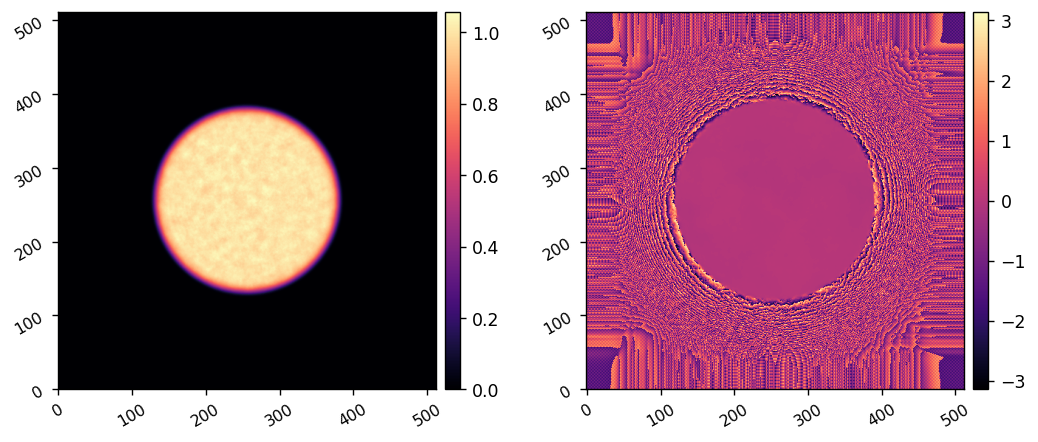

In [10]:
reload(hcim)
c = hcim.PC(influence_functions=influence_functions,
         dm1_dm2=1000*u.mm,
         aberration_distance=500e-3*u.m)

aberrated_pupil = c.wfe_at_distance(hci.Wavefront(c.aperture, c.wavelength.to_value(u.m)))
wfsc.imshow2(aberrated_pupil.intensity.shaped, aberrated_pupil.phase.shaped)

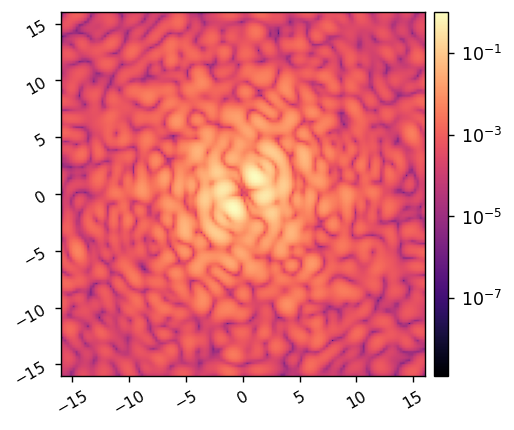

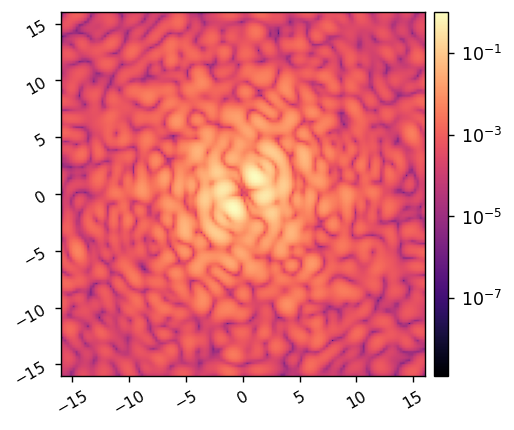

In [11]:
Nact = c.Nact
npsf = c.npsf

c.reset_dms()
ref_im = c.snap()
ref_max = ref_im.max()

misc.imshow1(ref_im/ref_max, lognorm=True, pxscl=c.psf_pixelscale_lamD)

c.norm = ref_max
im = c.snap()
misc.imshow1(im, lognorm=True, pxscl=c.psf_pixelscale_lamD)


# define the dark hole region

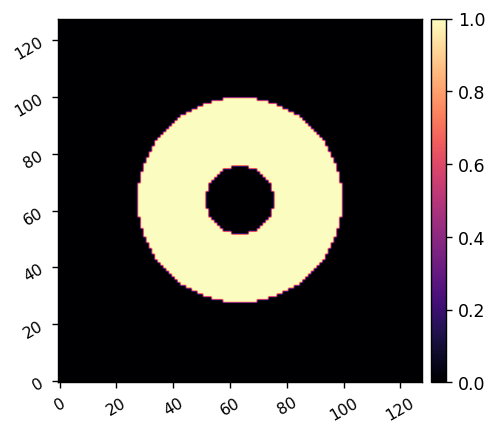

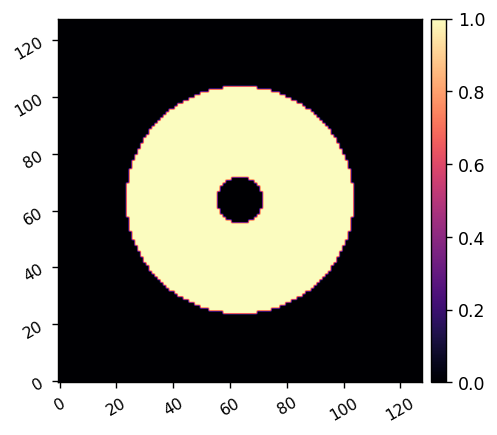

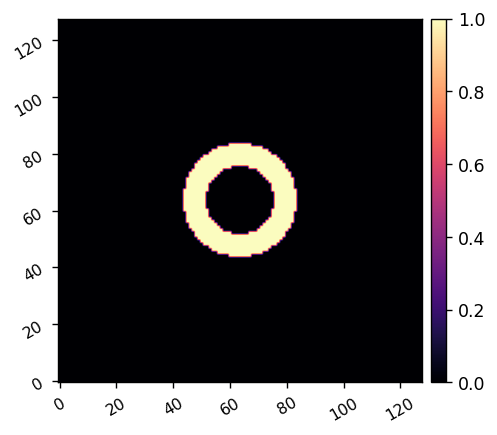

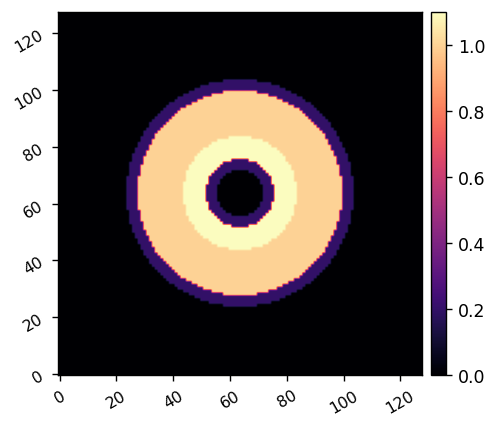

In [12]:
reload(wfsc)
reload(wfsc.utils)
reload(wfsc.imshows)
xfp = (np.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*c.psf_pixelscale_lamD
fpx,fpy = np.meshgrid(xfp,xfp)
fpr = np.sqrt(fpx**2 + fpy**2)

iwa = 3
owa = 9
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
#         'edge' : 2.5,
        'rotation':0,
        'full':True,
    }
roi1 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = (3-1)
owa = (9+1)
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
#         'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi2 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 3
owa = 5
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
#         'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi3 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

# wfsc.imshow2(roi1, roi2)
weight_map = roi1 + 0.2*(roi2 * ~roi1) + 0.1*roi3
control_mask = weight_map>0
wfsc.imshow1(weight_map)

probe_amp = 3e-8
calib_amp = 5e-9

(376, 1156)

(188, 2)

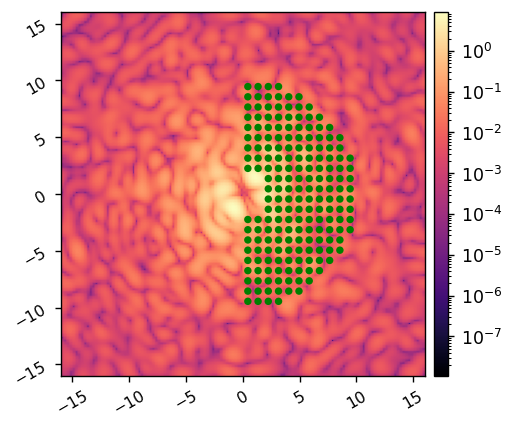

In [18]:
reload(wfsc.utils)
fourier_modes, fs = wfsc.utils.select_fourier_modes(c, control_mask*(fpx>0), fourier_sampling=0.9) 
nmodes = fourier_modes.shape[0]
nf = fourier_modes.shape[0]//2
display(fourier_modes.shape, fs.shape)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
    
wfsc.imshow1(ref_im, lognorm=True, pxscl=c.psf_pixelscale_lamD, patches=patches)

In [1]:
492*33.6/3600

4.5920000000000005

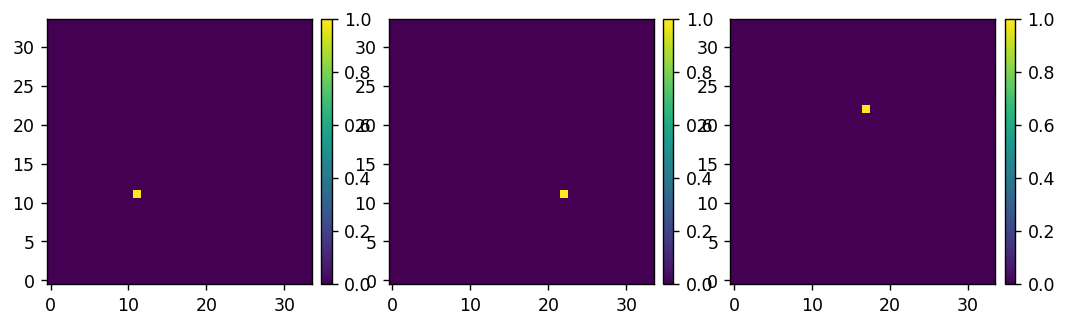

In [15]:
reload(wfsc.utils)
# probe_modes_1 = wfsc.utils.create_fourier_probes(fourier_modes, Nact=34, plot=True)
# probe = 1/np.sqrt(2) * np.sum((fourier_modes[:nf] + fourier_modes[nf:]), axis=0).reshape(Nact,Nact)
# probe /= probe.max()
# wfsc.imshow1(probe)

# probe_modes = np.array([probe_modes_1[0], probe, probe_modes_1[1]])
# wfsc.imshow3(probe_modes[0], probe_modes[1], probe_modes[2])

# probe_modes = wfsc.utils.create_probe_poke_modes(Nact, 
#                                                  poke_indices=[(Nact//5, Nact//2), (Nact//5+1, Nact//2)], 
#                                                  plot=True)

probe_modes = wfsc.utils.create_probe_poke_modes(Nact, 
                                                 poke_indices=[(Nact//3, Nact//3), 
                                                               (2*Nact//3, Nact//3), 
                                                               (Nact//2, 2*Nact//3)], 
                                                 plot=True)


# probe_modes = probe_modes_1 + probe_modes_2

# wfsc.imshow2(probe_modes[0], probe_modes[1])

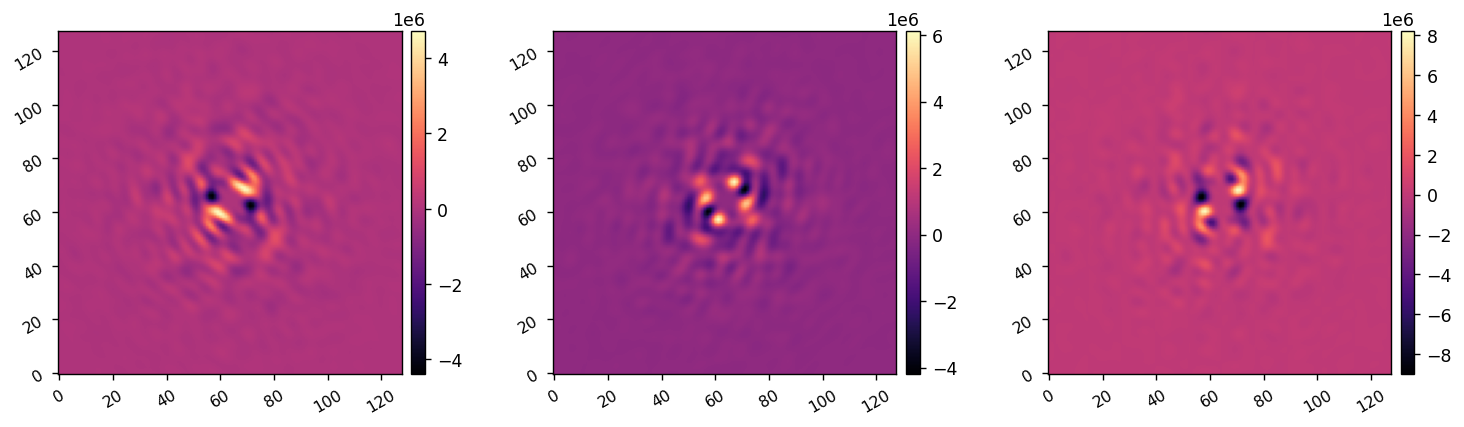

In [19]:
reload(wfsc.iefc_2dm)

probe_amp = 5e-8
calib_amp = 5e-9

# c.texp = 1

c.reset_dms()

differential_images, single_images = wfsc.iefc_2dm.take_measurement(c, 
                                                                   probe_modes, probe_amp, 
                                                                   return_all=True)
ims = differential_images.reshape(3, c.npsf, c.npsf)
wfsc.imshow3(ims[0], ims[1], ims[0]-ims[1], wspace=0.35)

In [ ]:
reload(wfsc.iefc_2dm)
response_matrix, response_cube = wfsc.iefc_2dm.calibrate(c, 
                                                         control_mask.ravel(),
                                                         probe_amp, probe_modes, 
                                                         calib_amp, fourier_modes, 
                                                         return_all=True)

Calibrating I-EFC...
	Calibrated mode 1 / 376 in 4.462s
	Calibrated mode 2 / 376 in 8.922s
	Calibrated mode 3 / 376 in 13.378s
	Calibrated mode 4 / 376 in 17.836s
	Calibrated mode 5 / 376 in 22.303s
	Calibrated mode 6 / 376 in 26.767s
	Calibrated mode 7 / 376 in 31.232s
	Calibrated mode 8 / 376 in 35.694s
	Calibrated mode 9 / 376 in 40.153s
	Calibrated mode 10 / 376 in 44.610s
	Calibrated mode 11 / 376 in 49.078s
	Calibrated mode 12 / 376 in 53.549s
	Calibrated mode 13 / 376 in 57.974s
	Calibrated mode 14 / 376 in 62.444s
	Calibrated mode 15 / 376 in 66.904s
	Calibrated mode 16 / 376 in 71.377s
	Calibrated mode 17 / 376 in 75.828s
	Calibrated mode 18 / 376 in 80.286s
	Calibrated mode 19 / 376 in 84.751s
	Calibrated mode 20 / 376 in 89.223s
	Calibrated mode 21 / 376 in 93.679s
	Calibrated mode 22 / 376 in 98.143s
	Calibrated mode 23 / 376 in 102.613s
	Calibrated mode 24 / 376 in 107.076s
	Calibrated mode 25 / 376 in 111.542s
	Calibrated mode 26 / 376 in 116.009s
	Calibrated mode 27 / 37

In [ ]:
response_sum = np.sum(abs(response_cube), axis=(0,1))
misc.imshow1(response_sum.reshape(c.npsf,c.npsf))

In [17]:
misc.save_fits('hcipy_iefc_2dm_response_matrix_20230524.fits', response_matrix)
misc.save_fits('hcipy_iefc_2dm_response_cube_20230524.fits', response_cube)

Saved data to:  hcipy_iefc_2dm_response_matrix_20230524.fits
Saved data to:  hcipy_iefc_2dm_response_cube_20230524.fits


Running I-EFC...
	Closed-loop iteration 1 / 10


(792,)

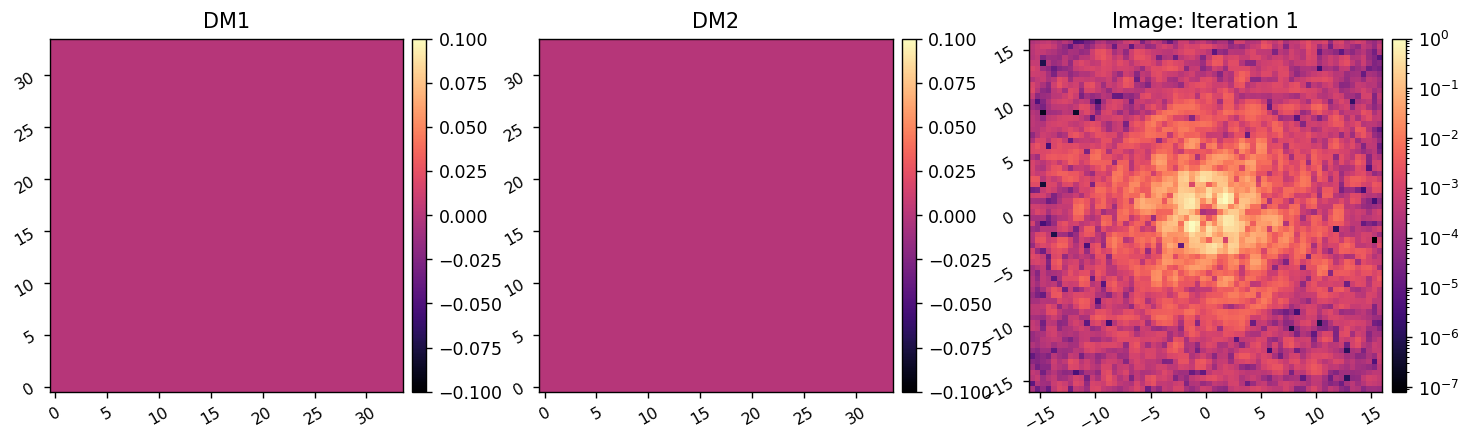

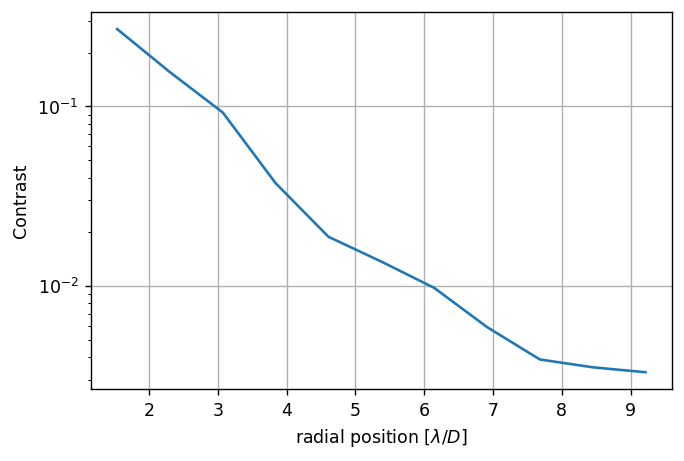

	Closed-loop iteration 2 / 10


(792,)

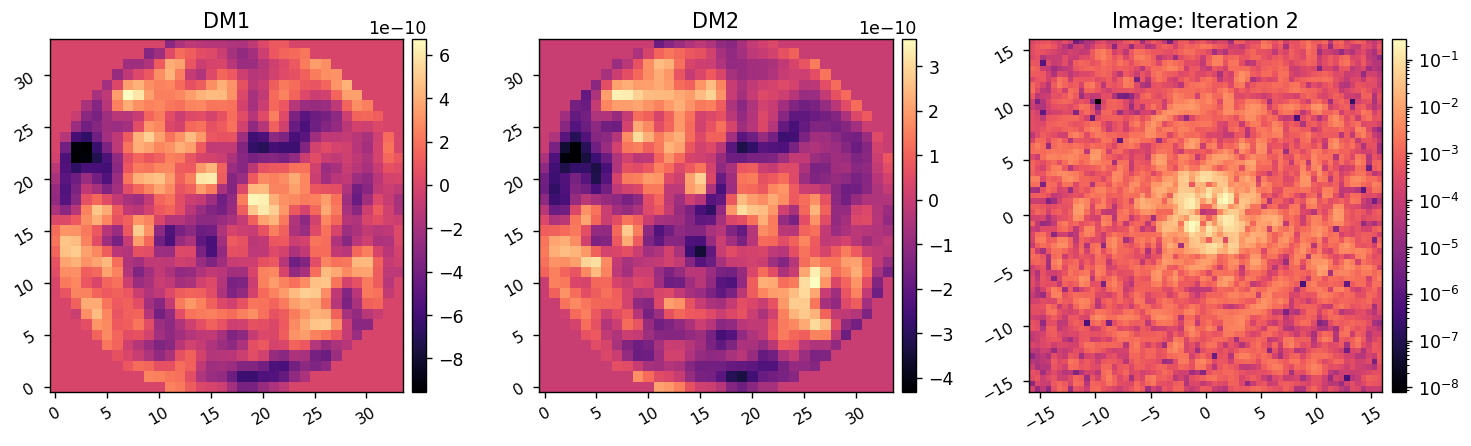

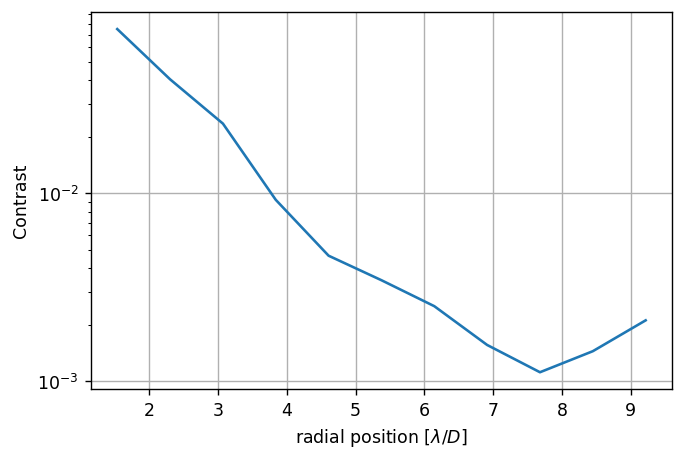

	Closed-loop iteration 3 / 10


(792,)

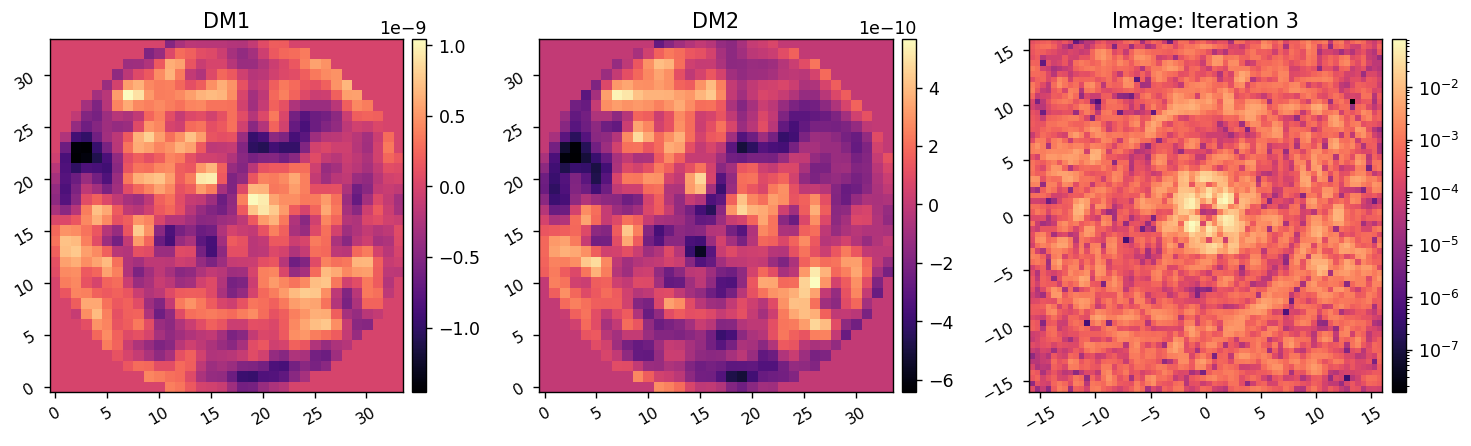

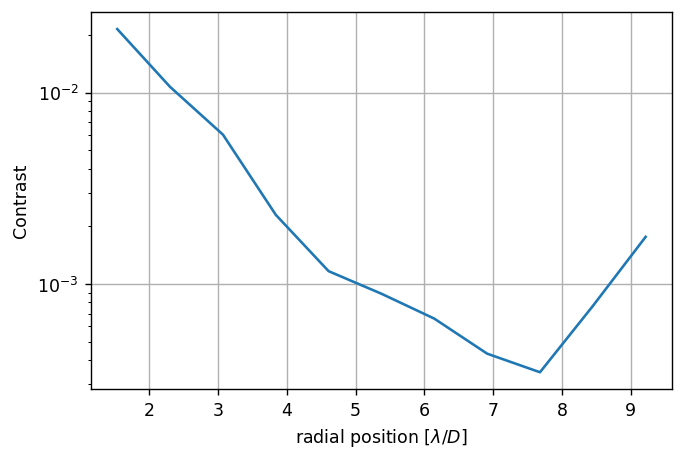

	Closed-loop iteration 4 / 10


(792,)

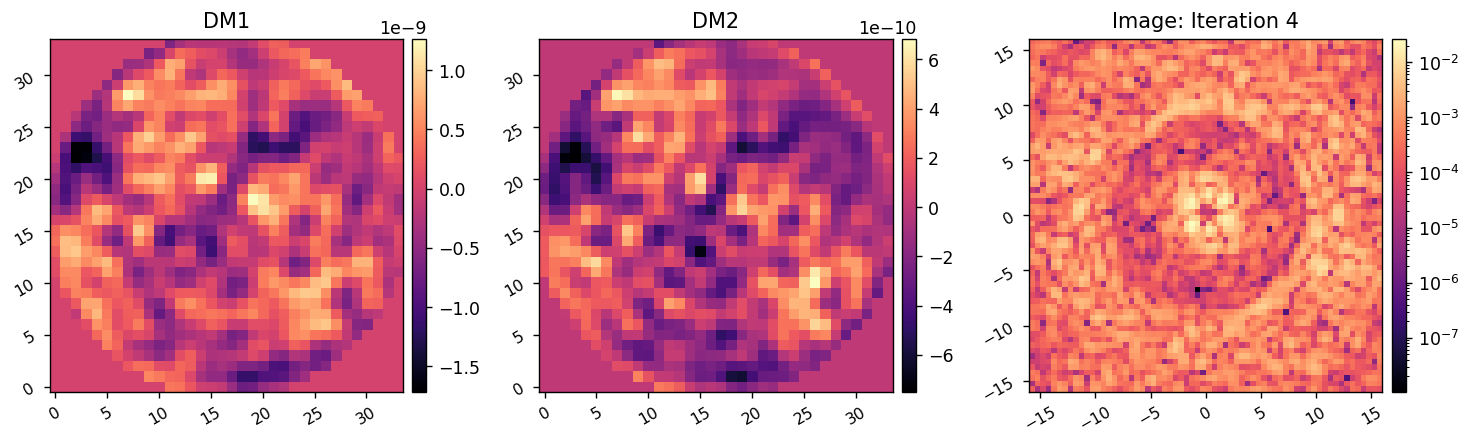

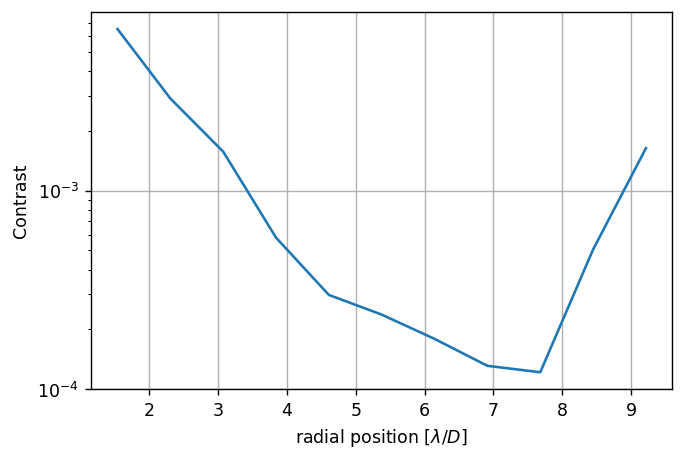

	Closed-loop iteration 5 / 10


(792,)

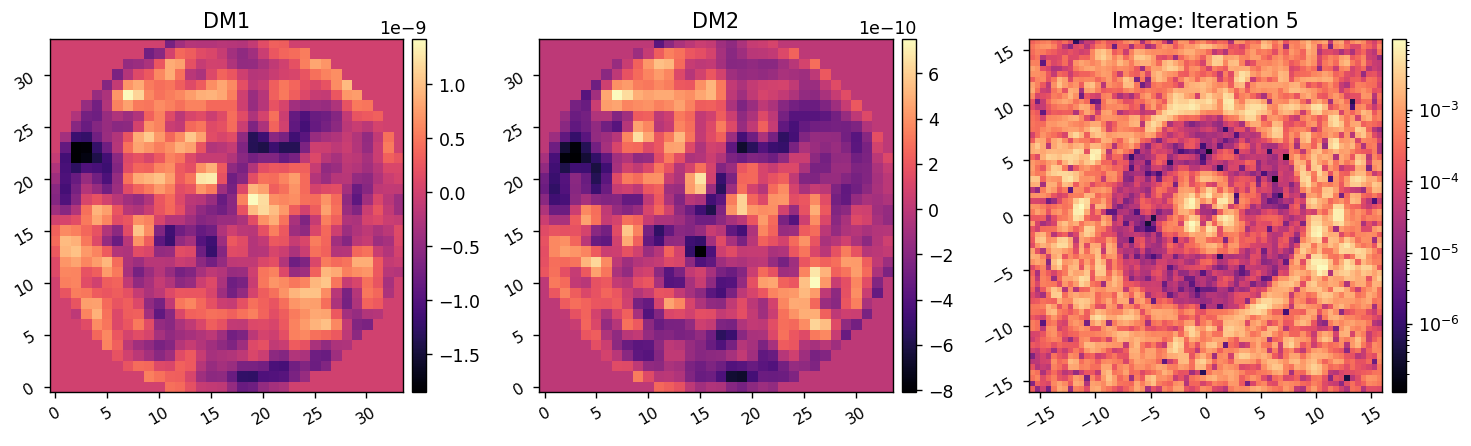

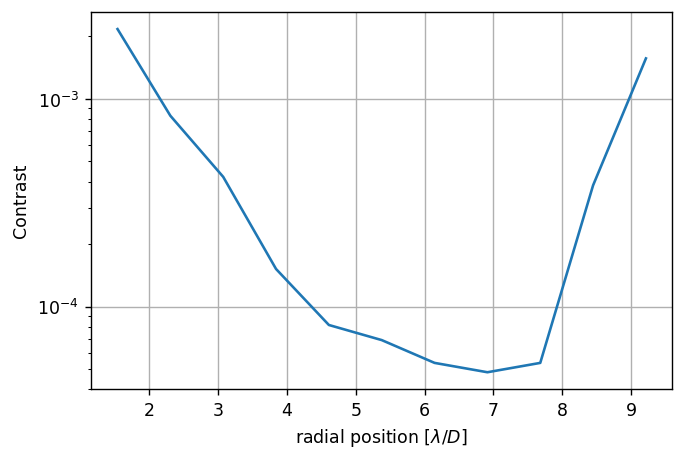

	Closed-loop iteration 6 / 10


(792,)

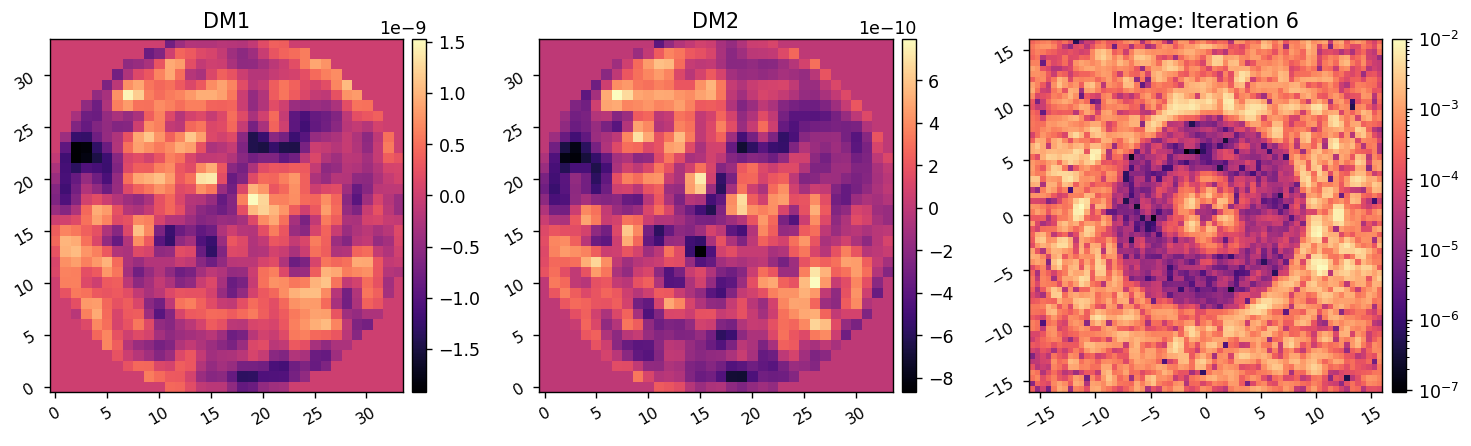

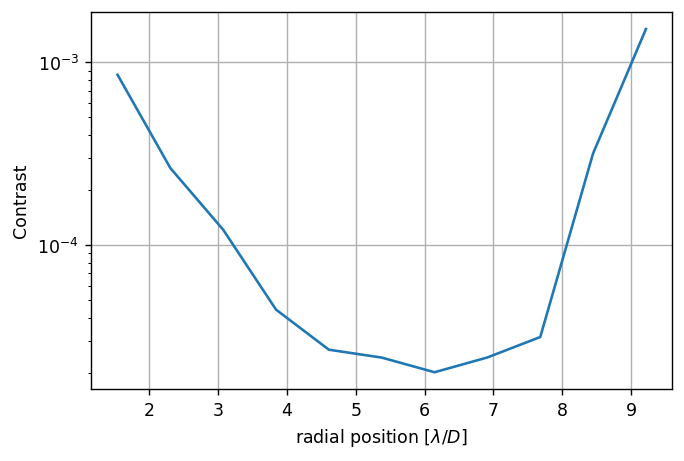

	Closed-loop iteration 7 / 10


(792,)

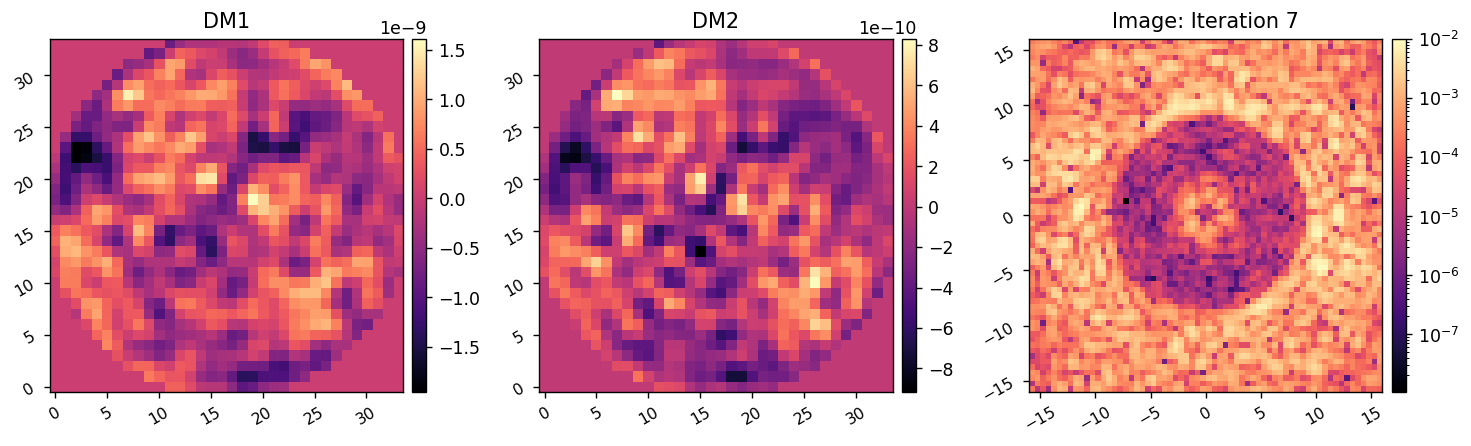

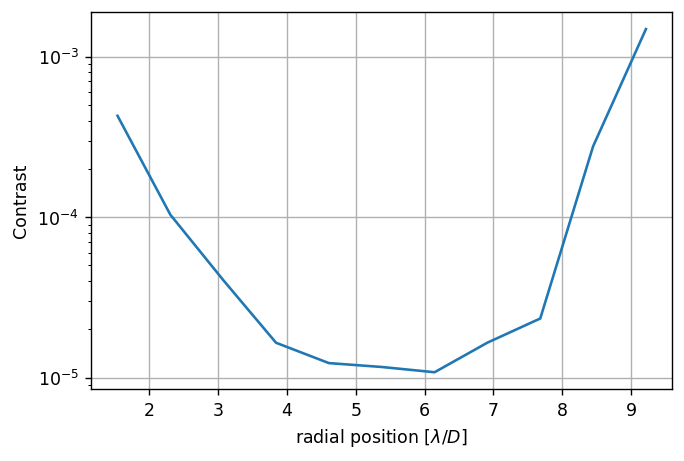

	Closed-loop iteration 8 / 10


(792,)

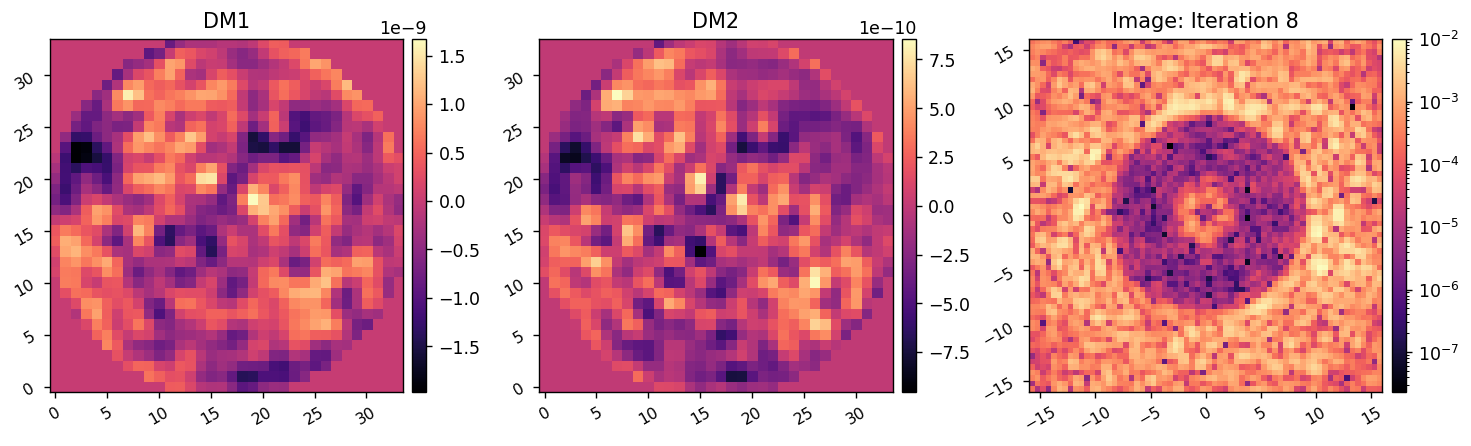

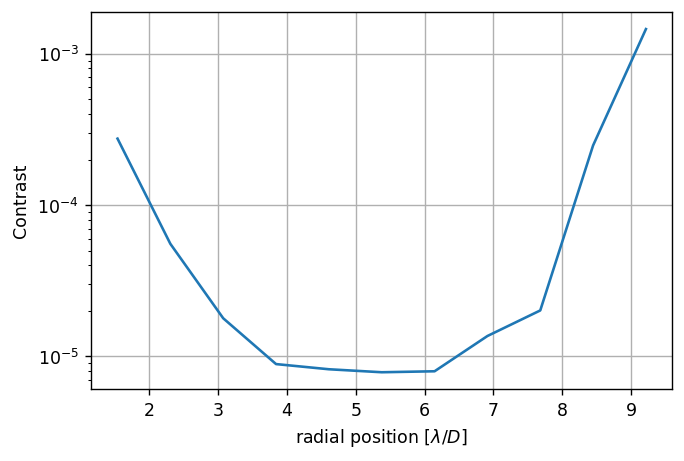

	Closed-loop iteration 9 / 10


(792,)

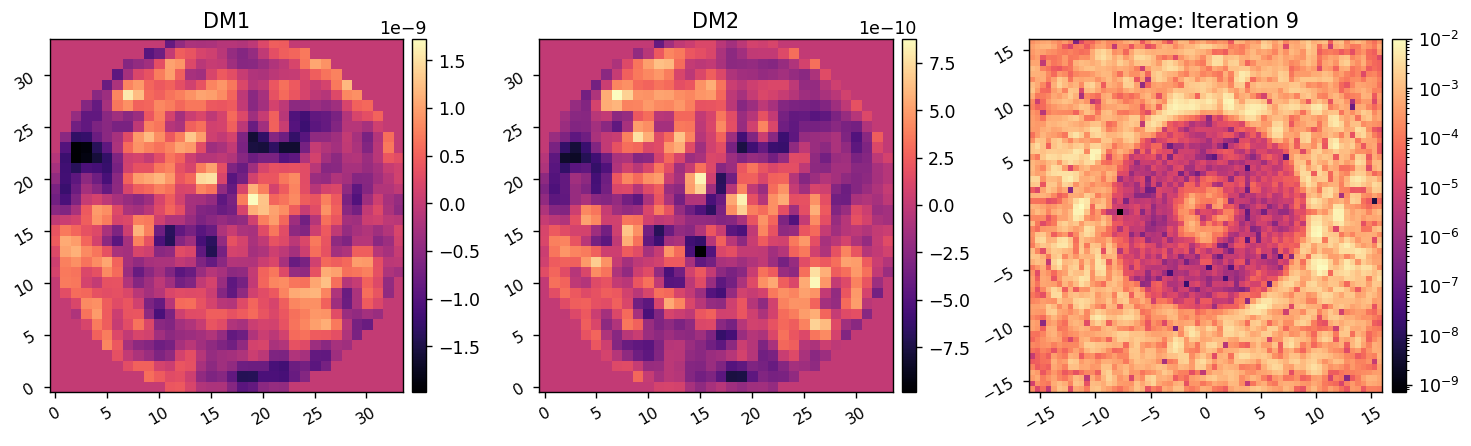

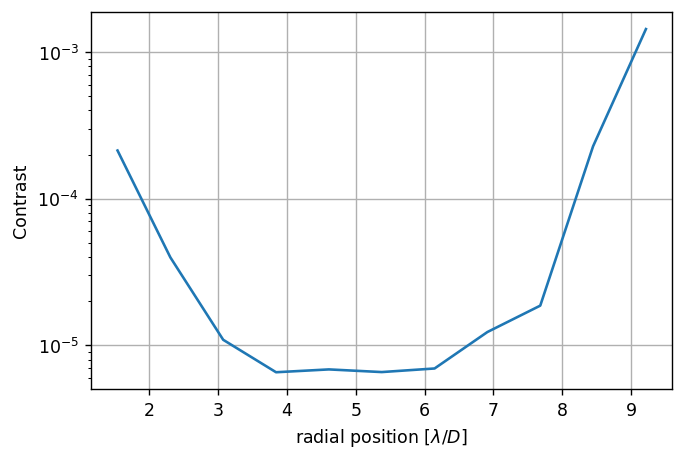

	Closed-loop iteration 10 / 10


(792,)

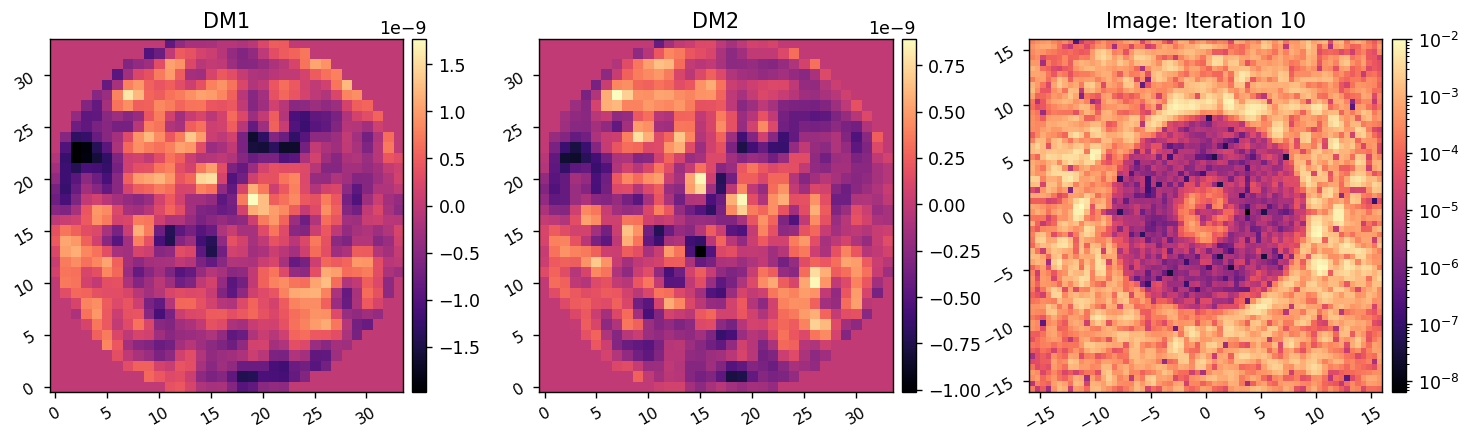

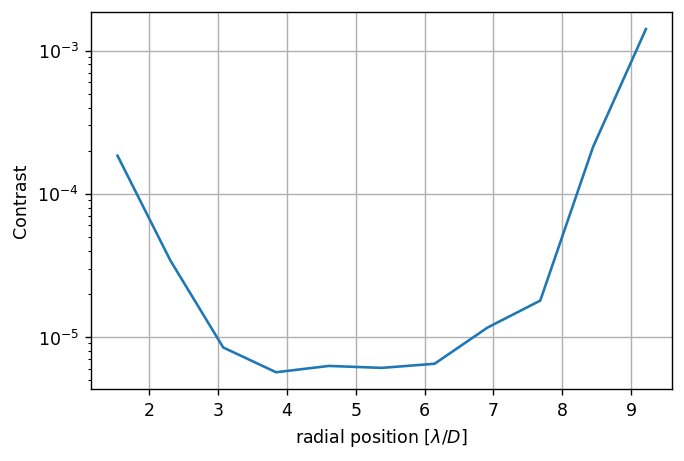

I-EFC loop completed in 21.409s.
Running I-EFC...
	Closed-loop iteration 1 / 20


(792,)

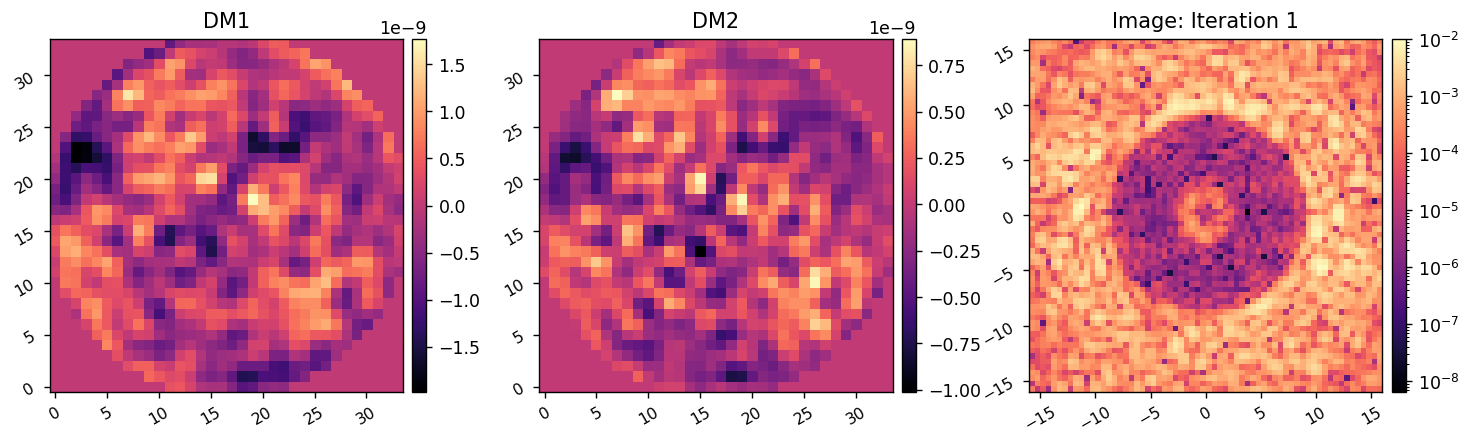

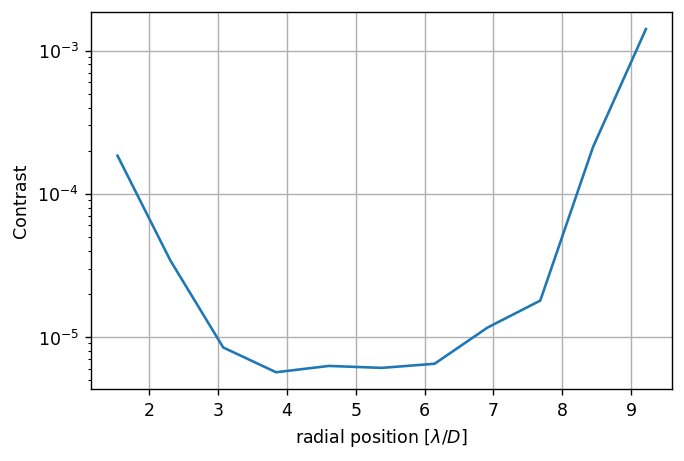

	Closed-loop iteration 2 / 20


(792,)

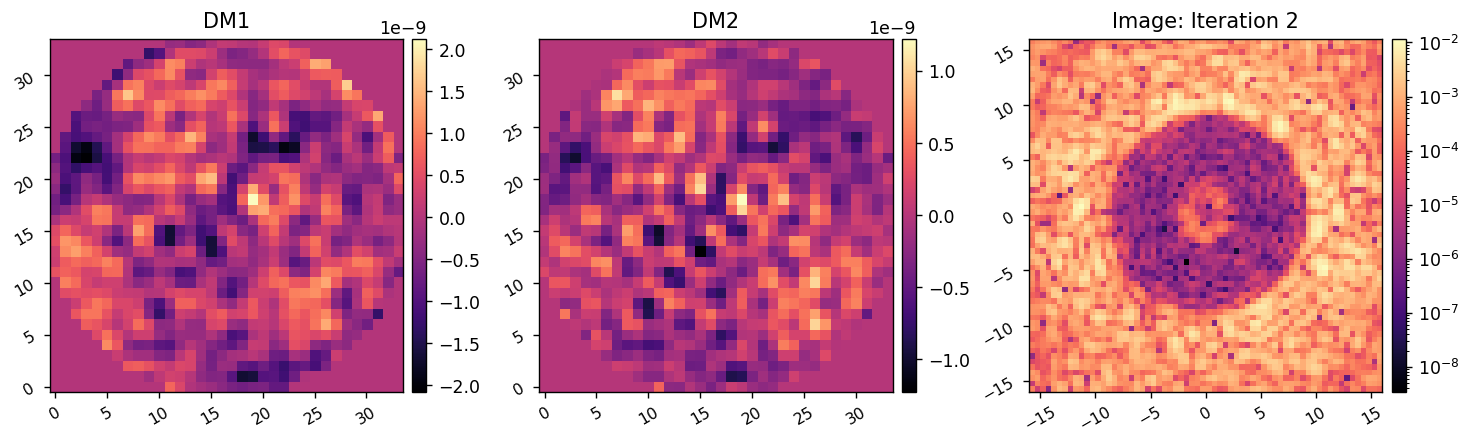

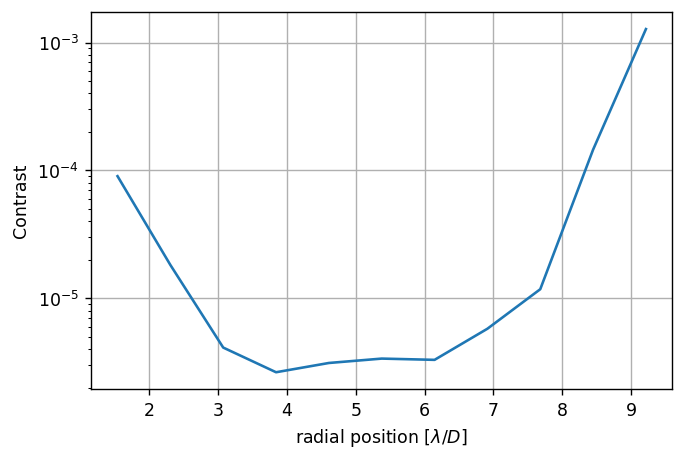

	Closed-loop iteration 3 / 20


(792,)

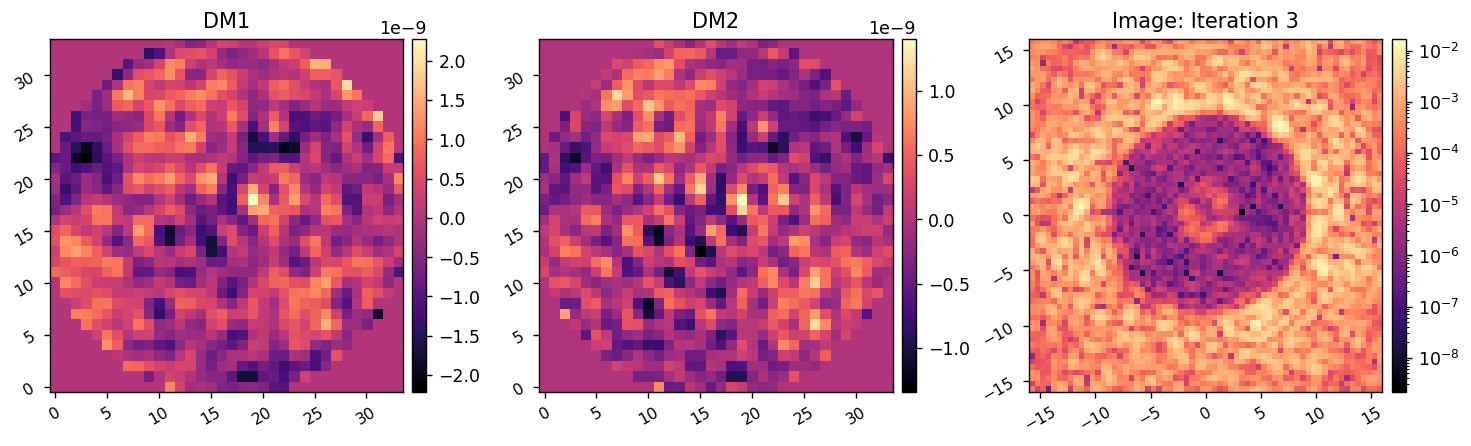

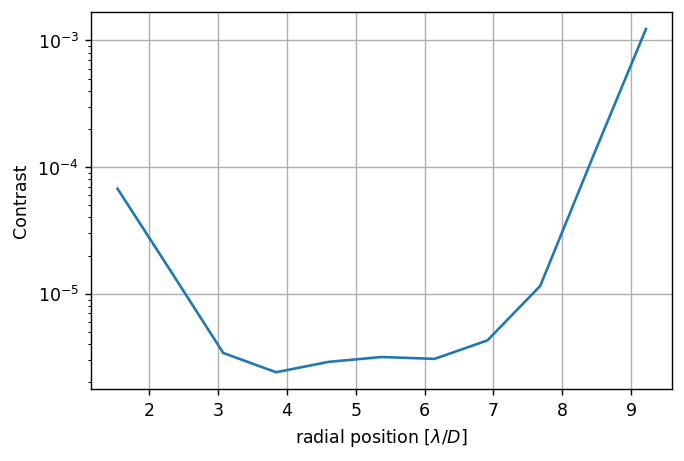

	Closed-loop iteration 4 / 20


(792,)

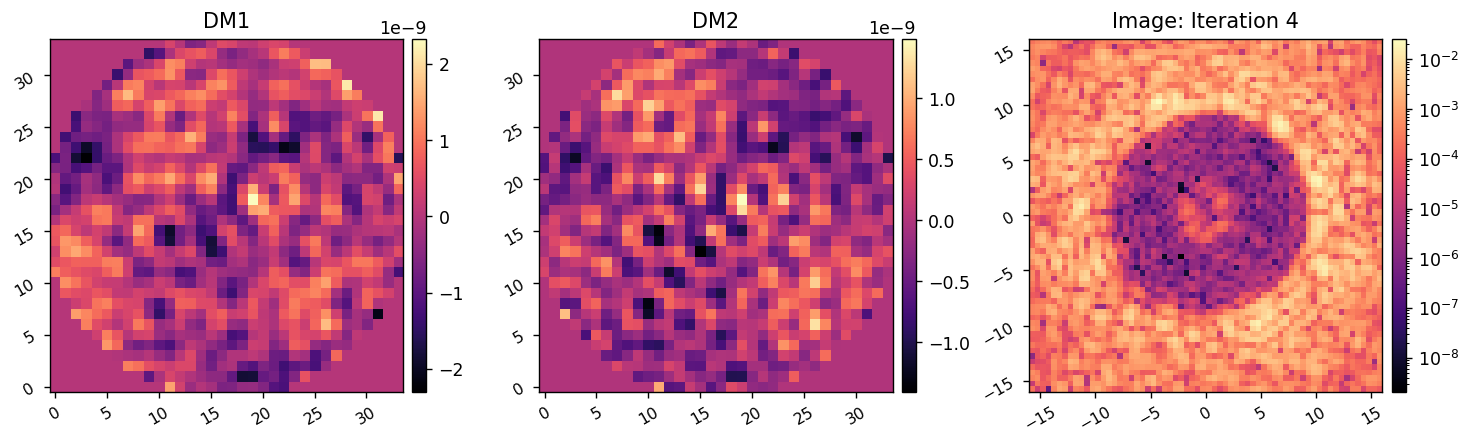

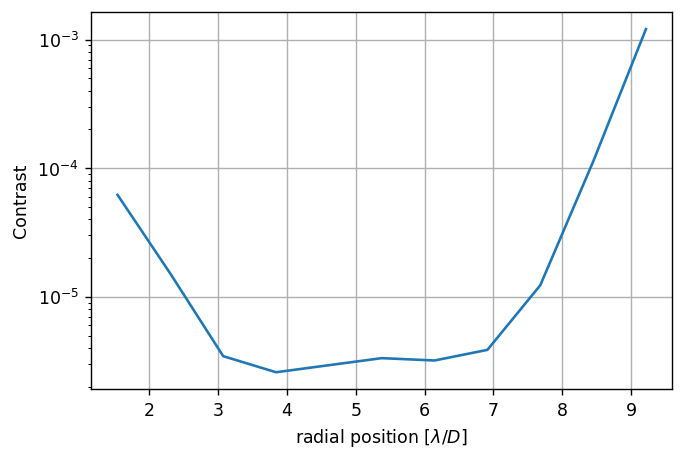

	Closed-loop iteration 5 / 20


(792,)

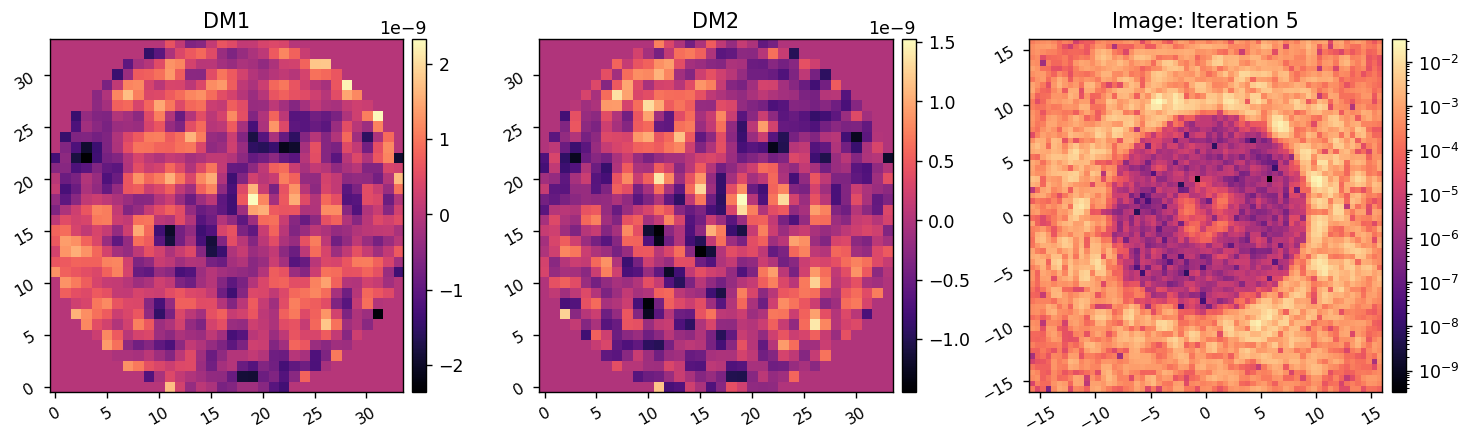

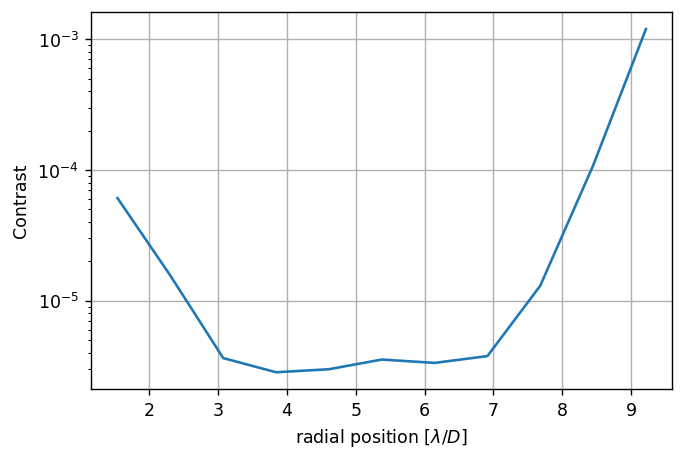

	Closed-loop iteration 6 / 20


(792,)

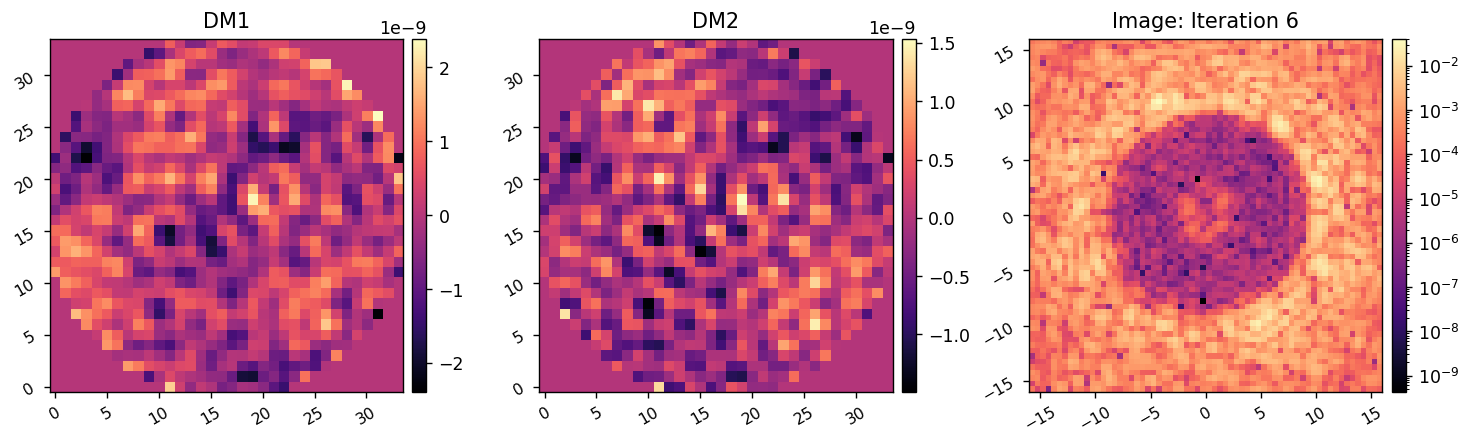

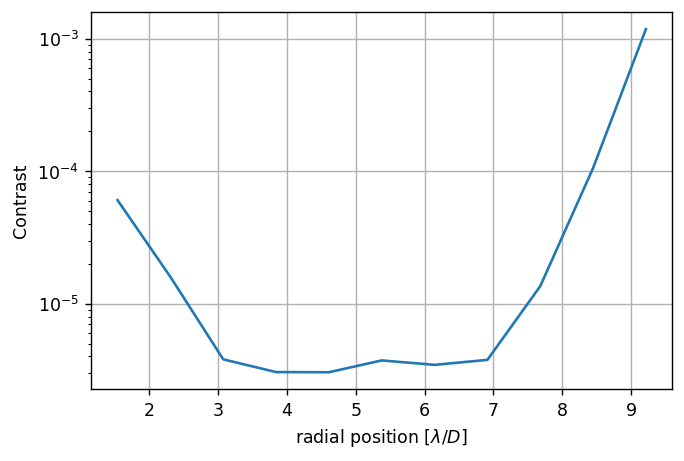

	Closed-loop iteration 7 / 20


(792,)

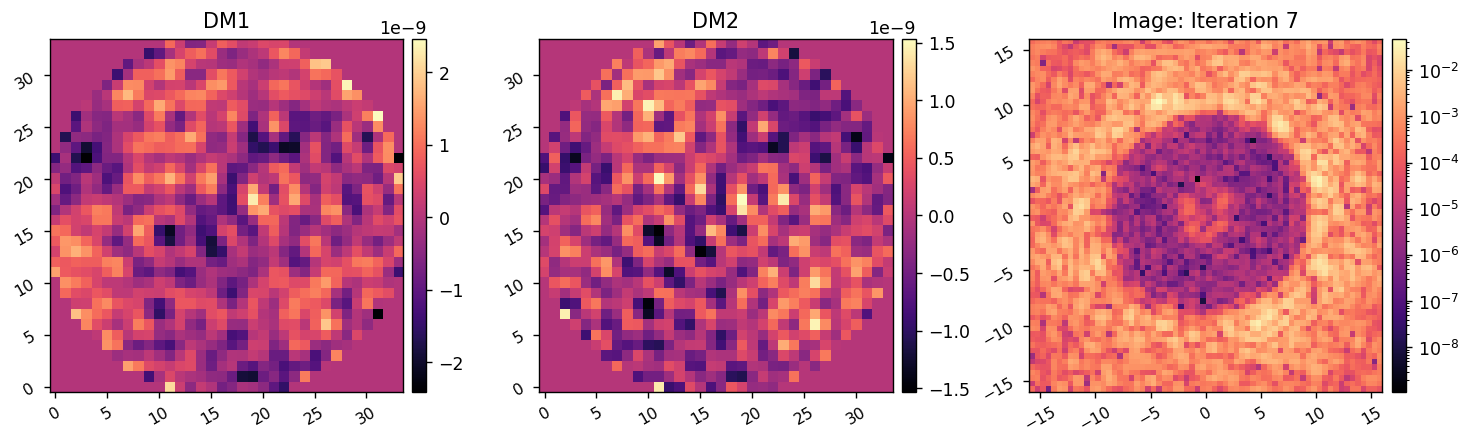

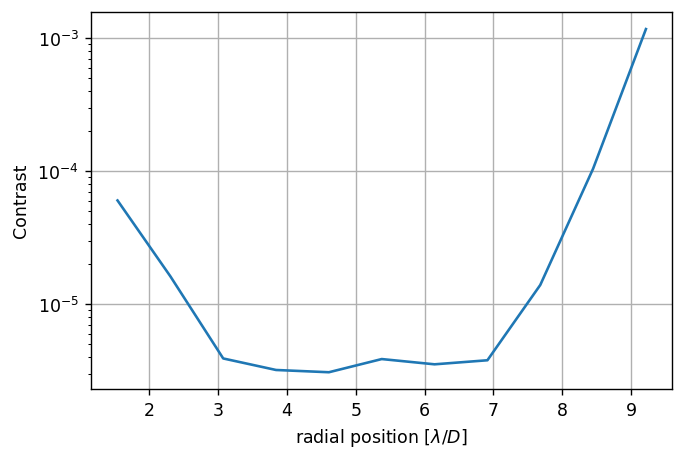

	Closed-loop iteration 8 / 20


(792,)

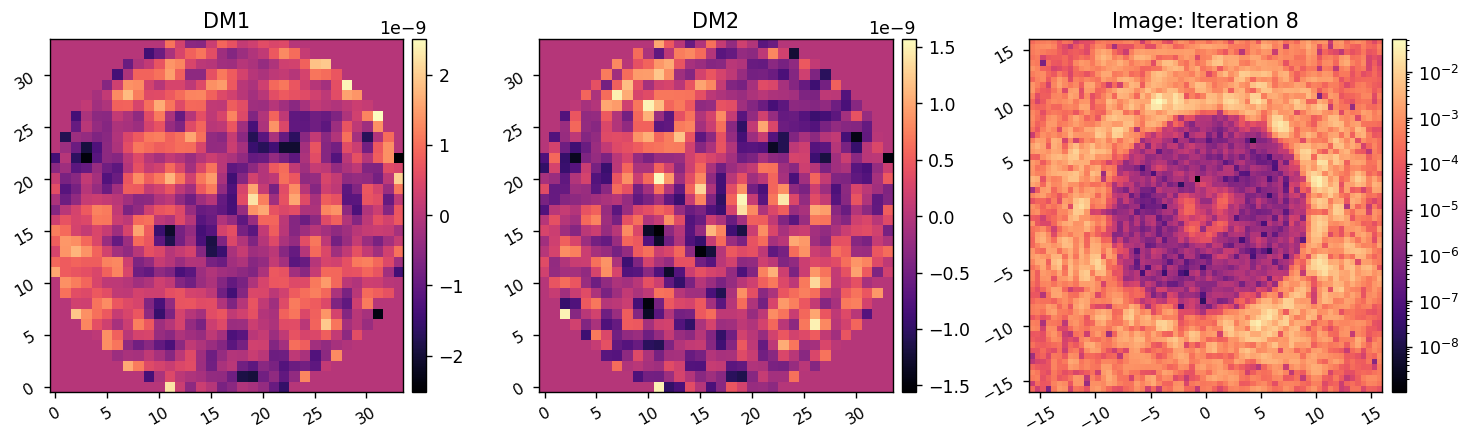

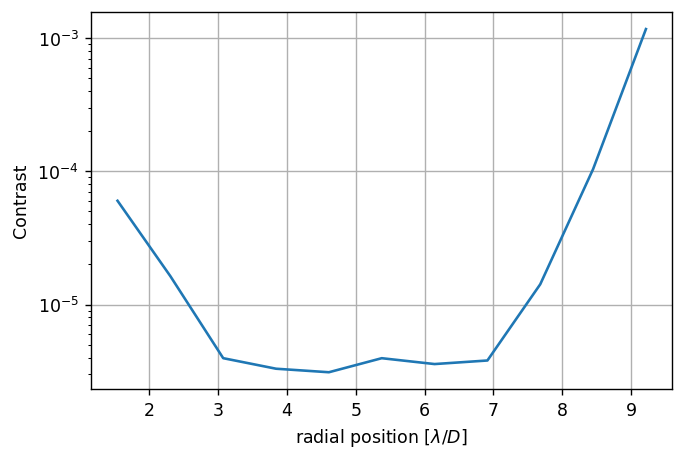

	Closed-loop iteration 9 / 20


(792,)

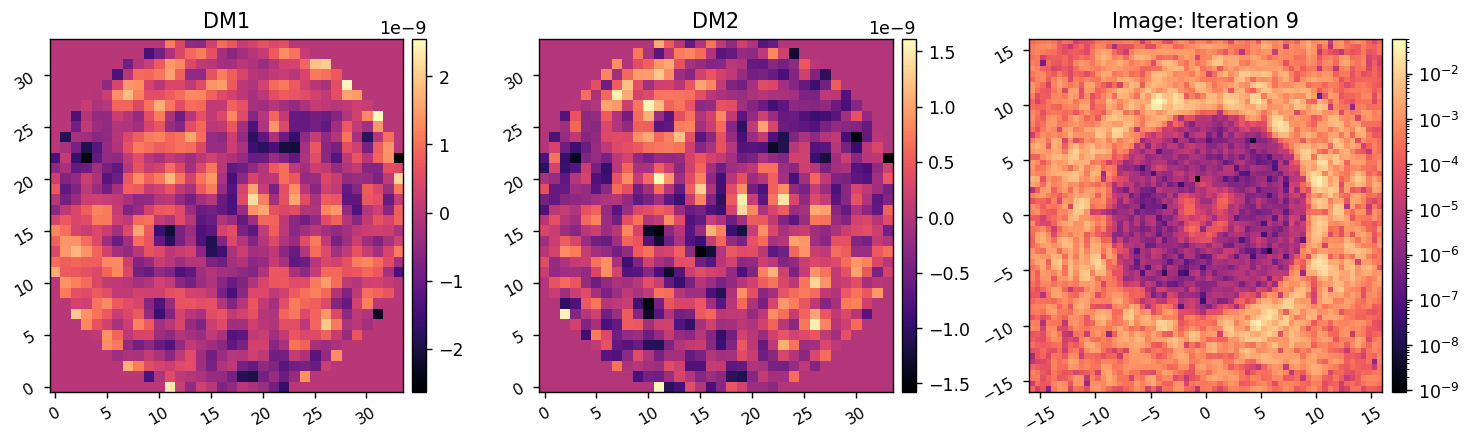

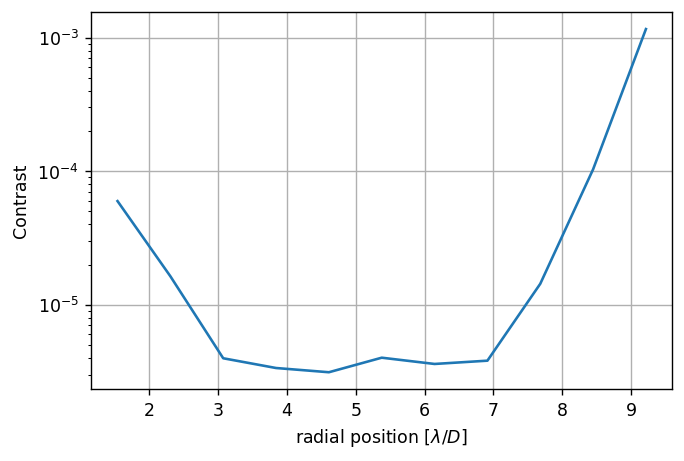

	Closed-loop iteration 10 / 20


(792,)

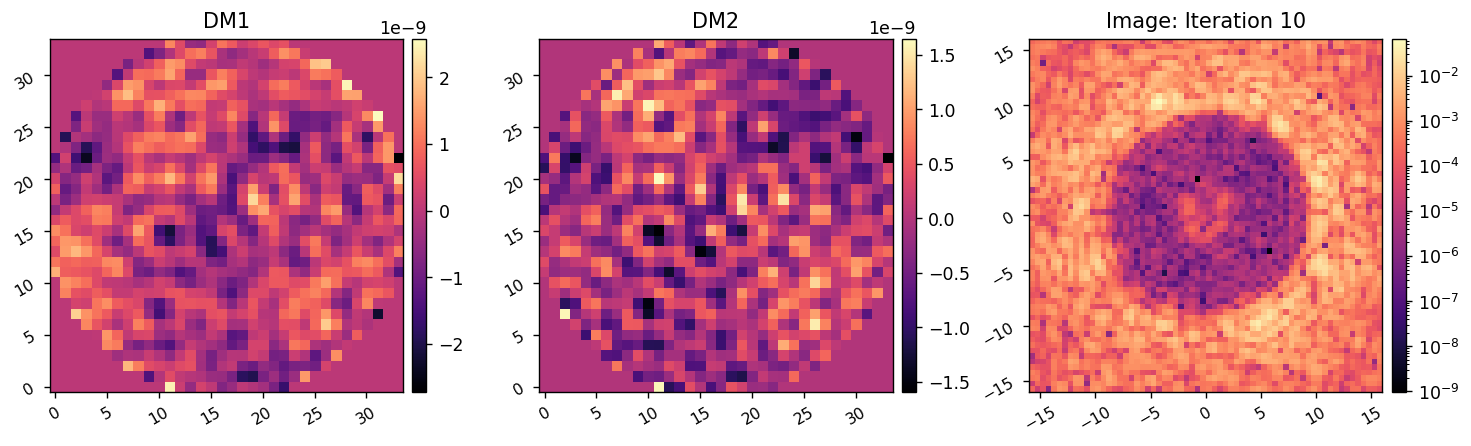

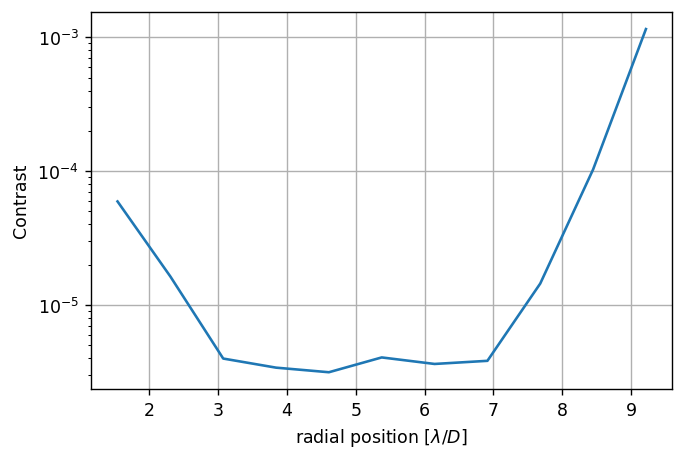

	Closed-loop iteration 11 / 20


(792,)

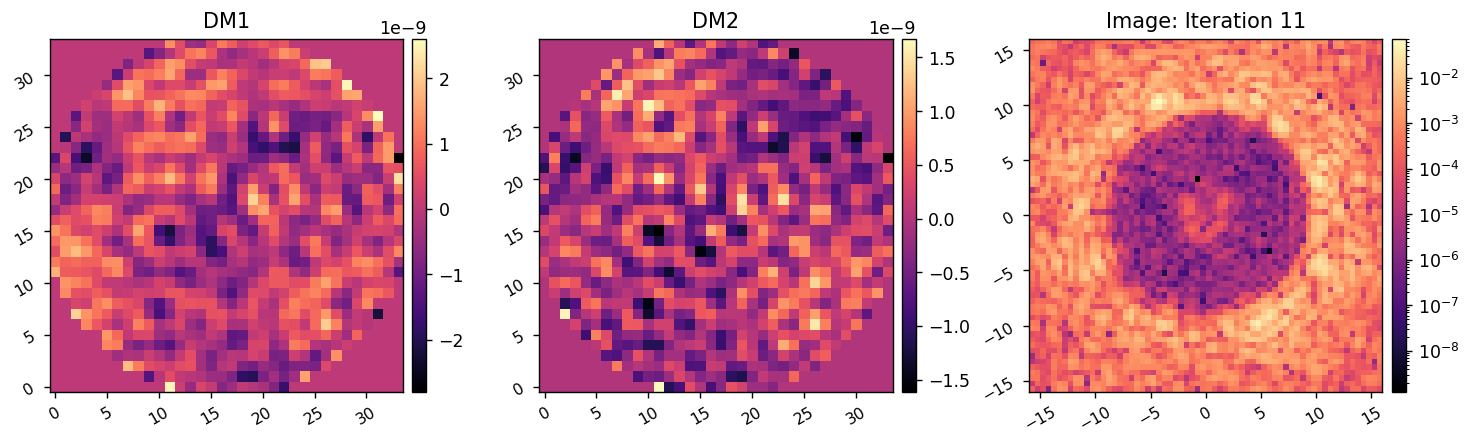

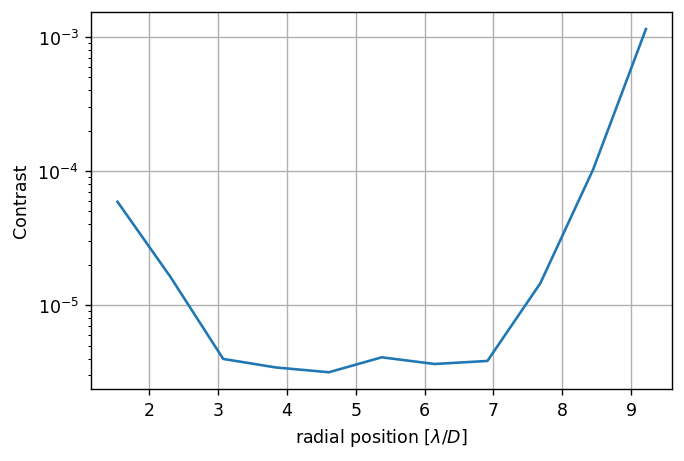

	Closed-loop iteration 12 / 20


(792,)

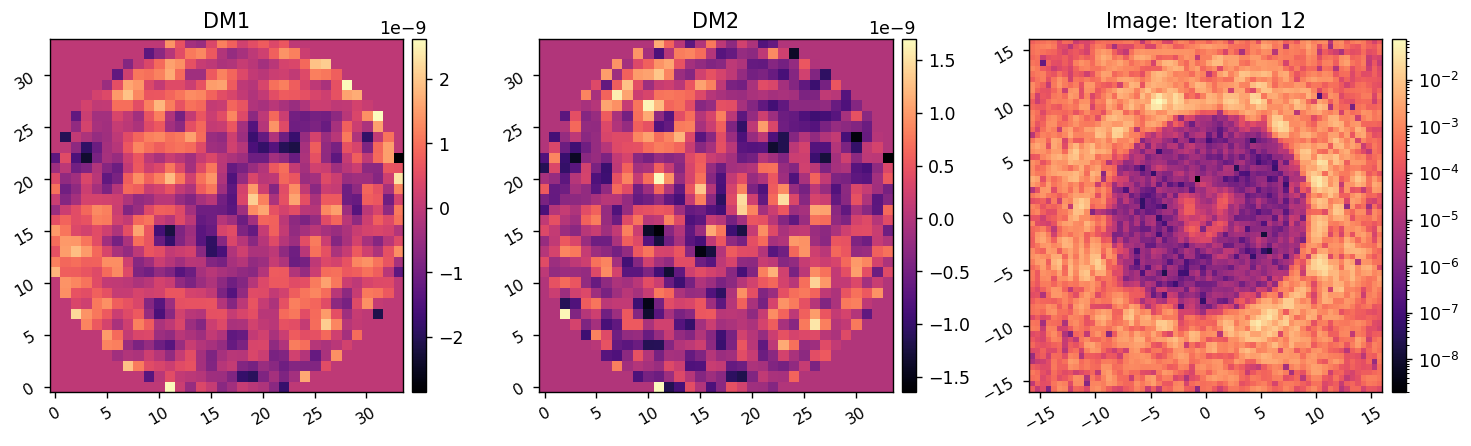

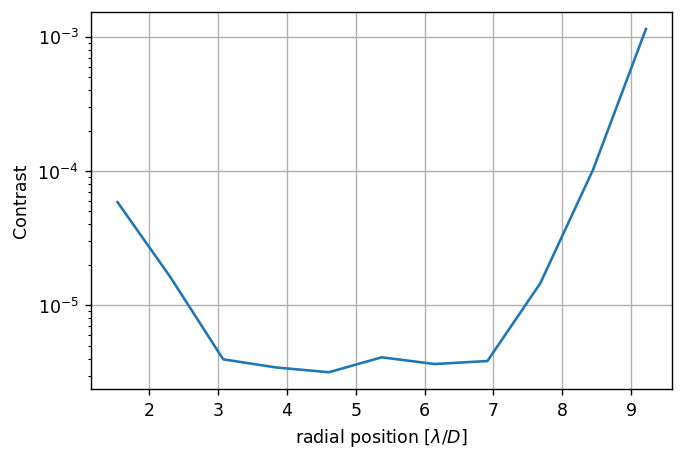

	Closed-loop iteration 13 / 20


(792,)

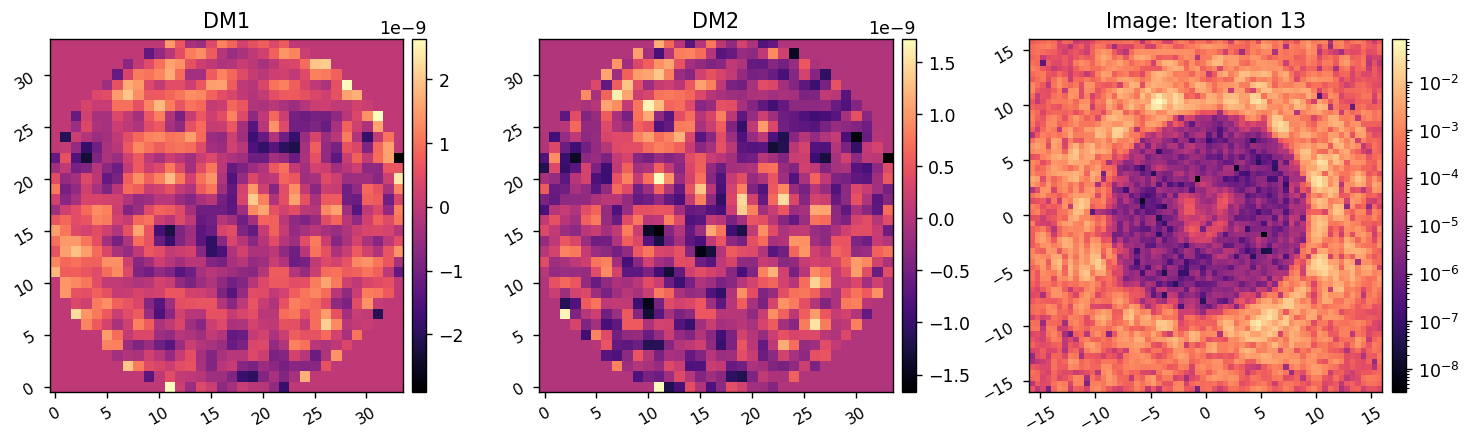

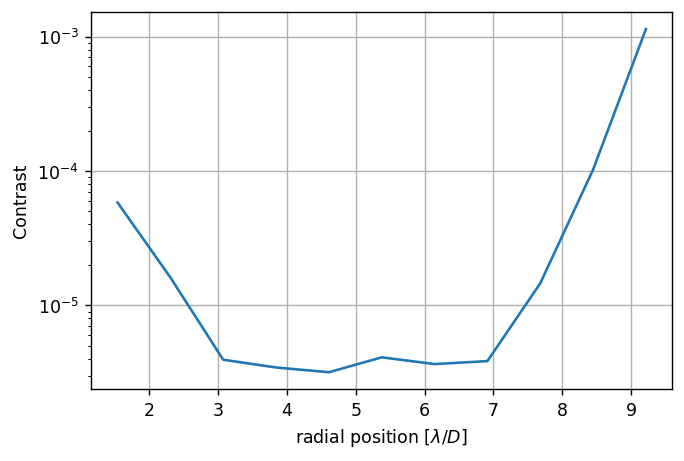

	Closed-loop iteration 14 / 20


(792,)

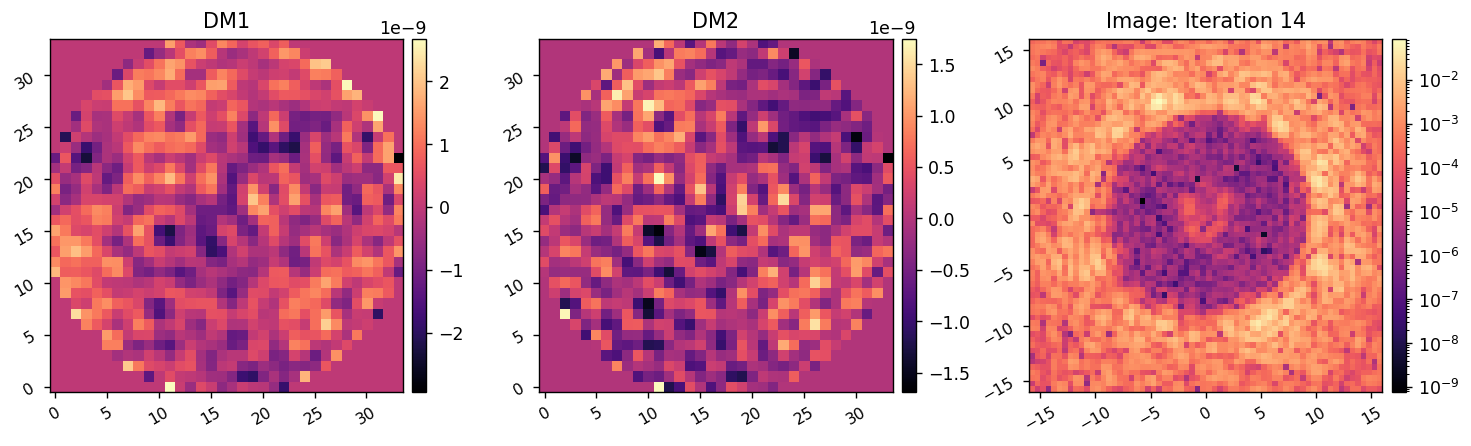

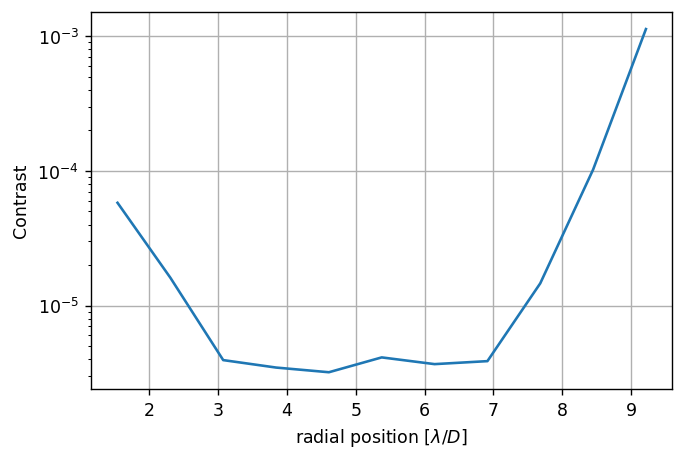

	Closed-loop iteration 15 / 20


(792,)

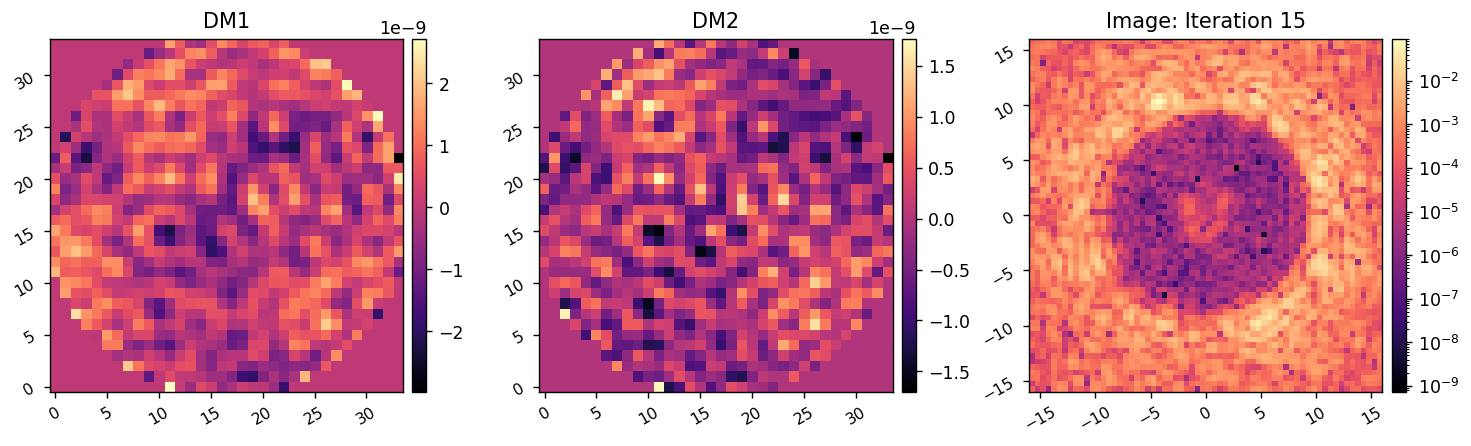

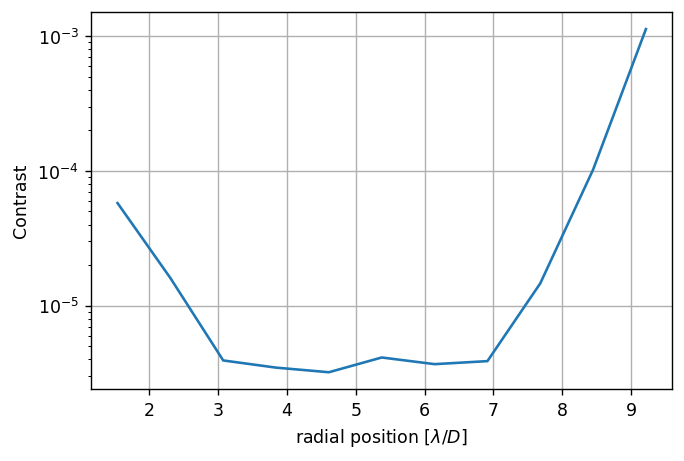

	Closed-loop iteration 16 / 20


(792,)

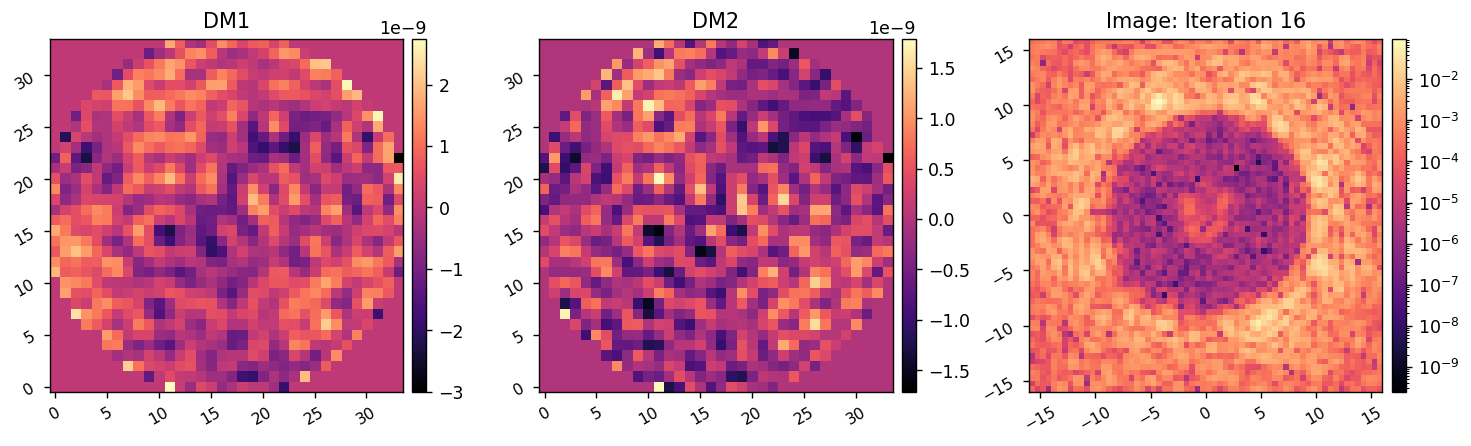

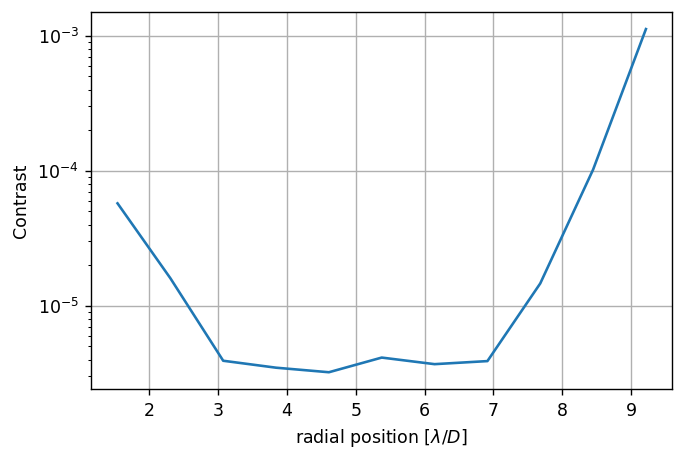

	Closed-loop iteration 17 / 20


(792,)

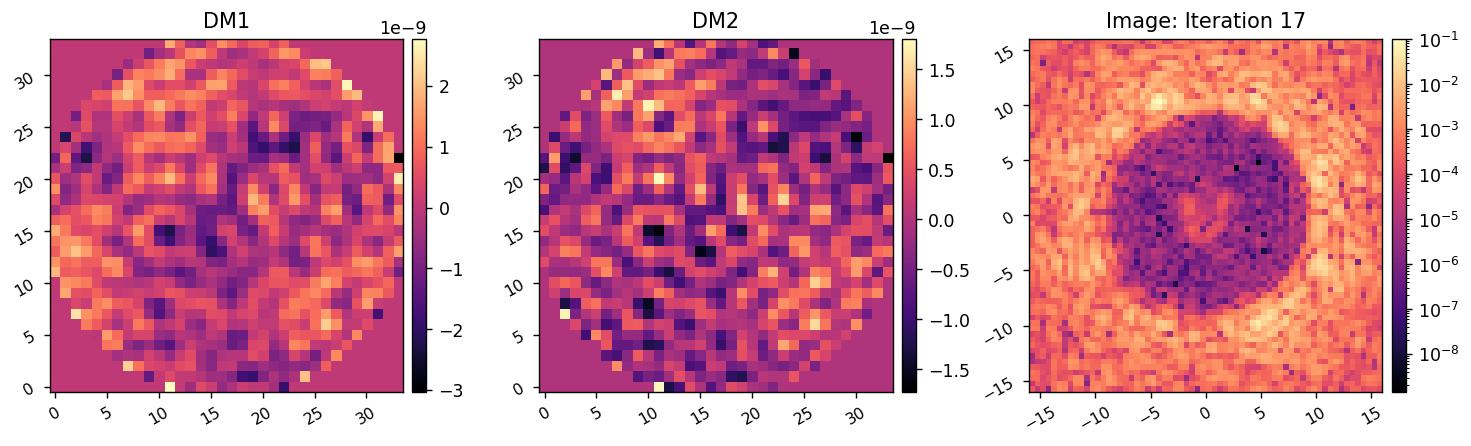

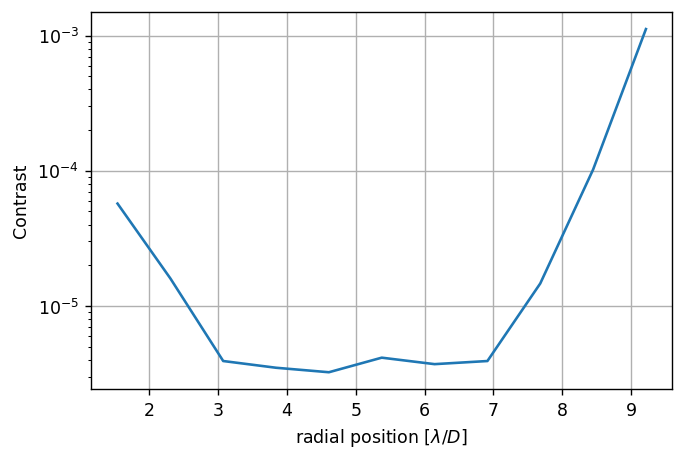

	Closed-loop iteration 18 / 20


(792,)

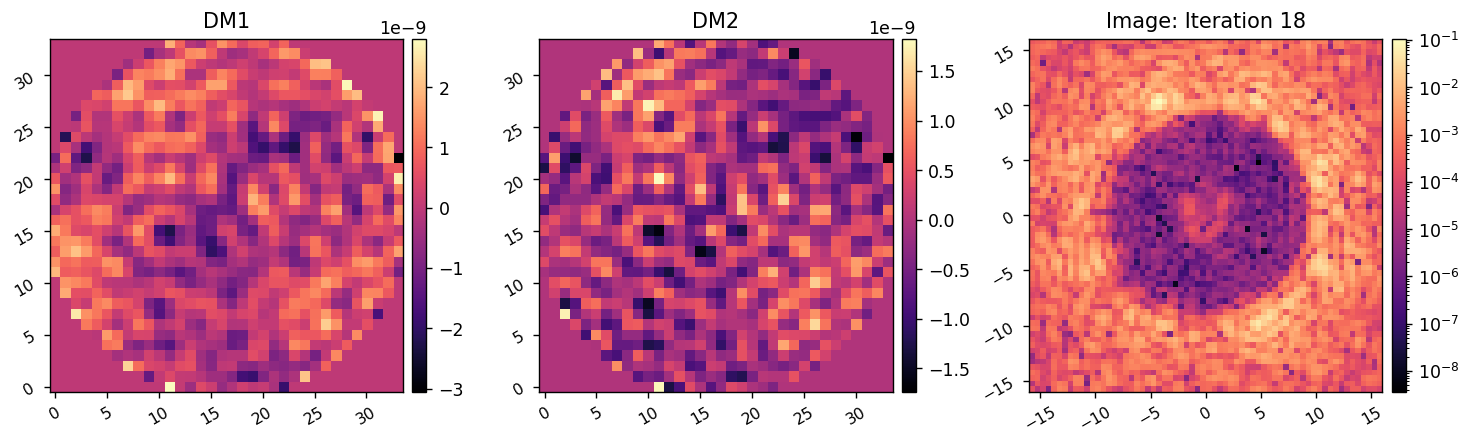

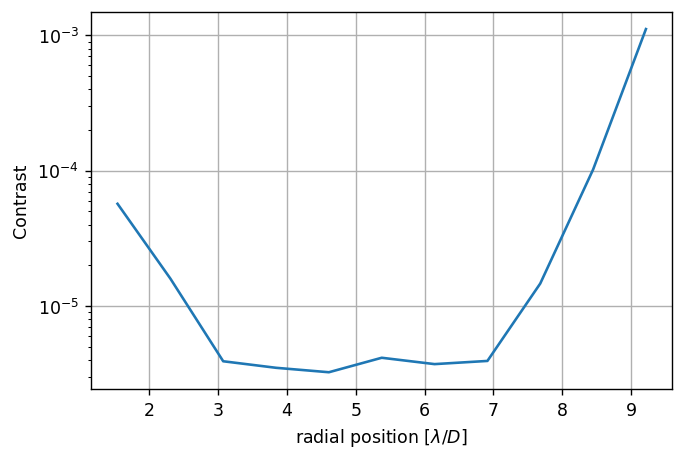

	Closed-loop iteration 19 / 20


(792,)

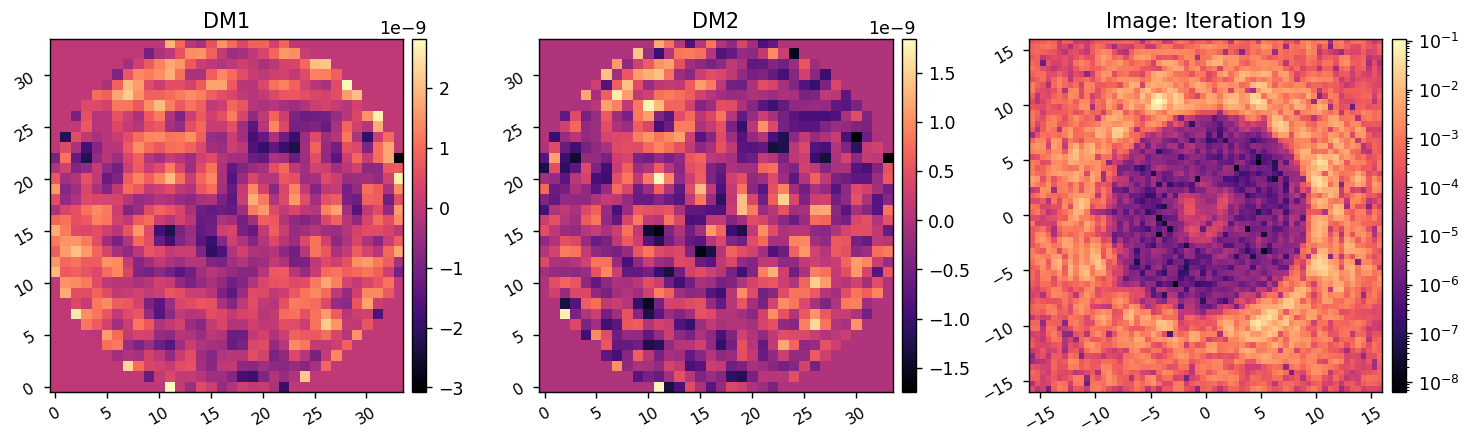

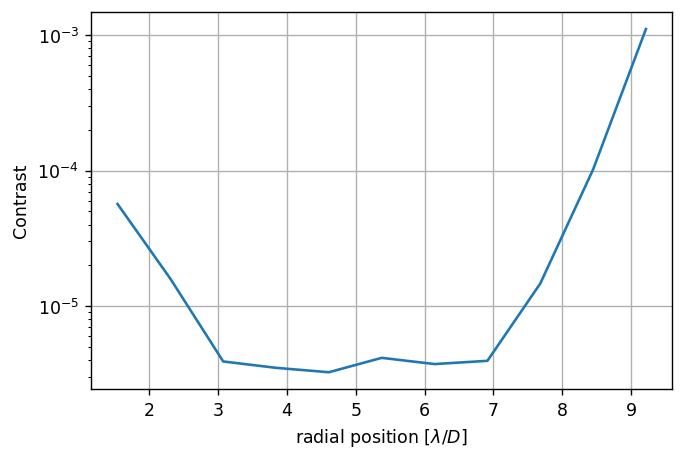

	Closed-loop iteration 20 / 20


(792,)

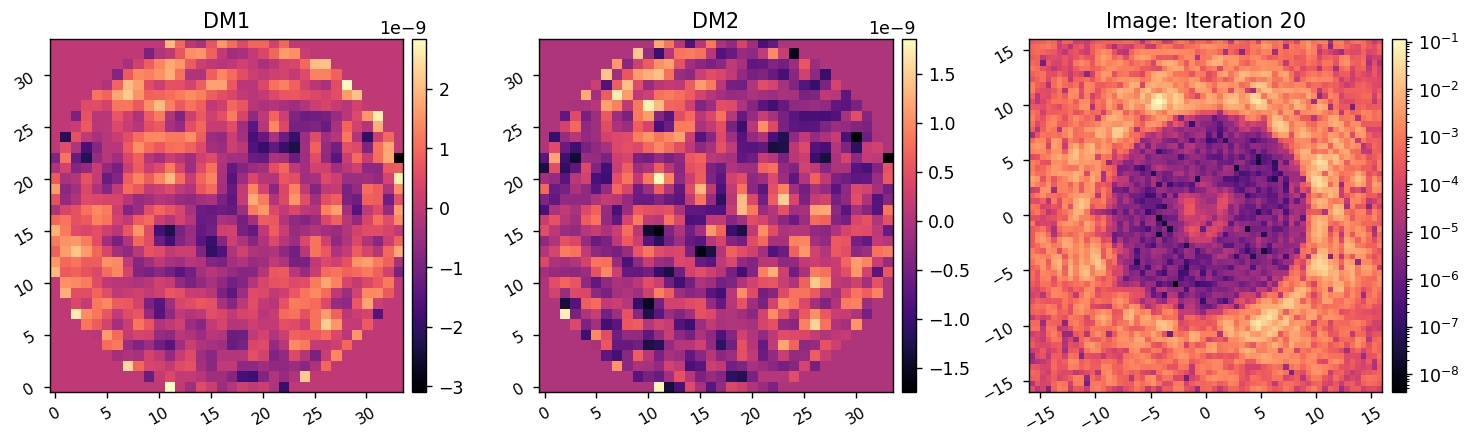

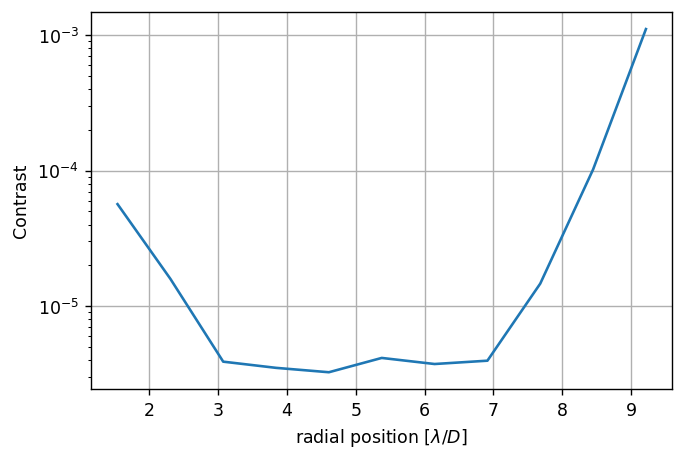

I-EFC loop completed in 43.570s.
Running I-EFC...
	Closed-loop iteration 1 / 10


(792,)

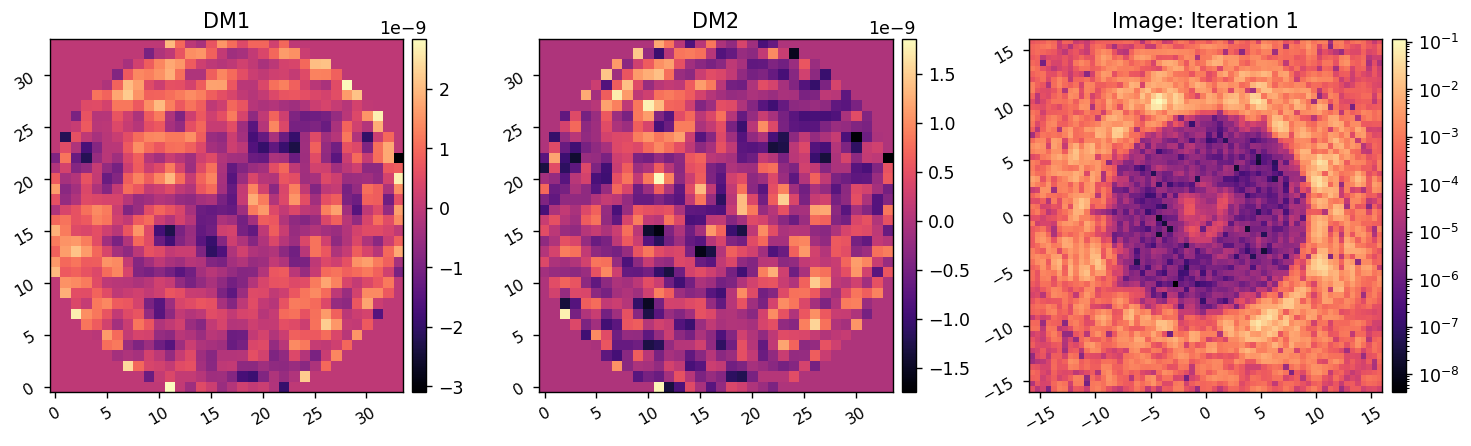

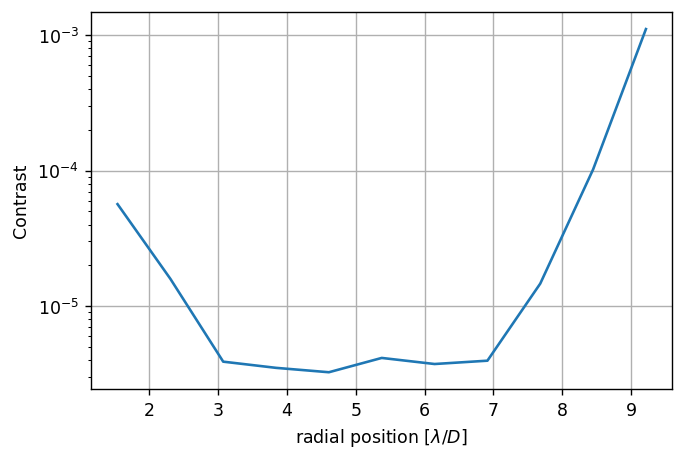

	Closed-loop iteration 2 / 10


(792,)

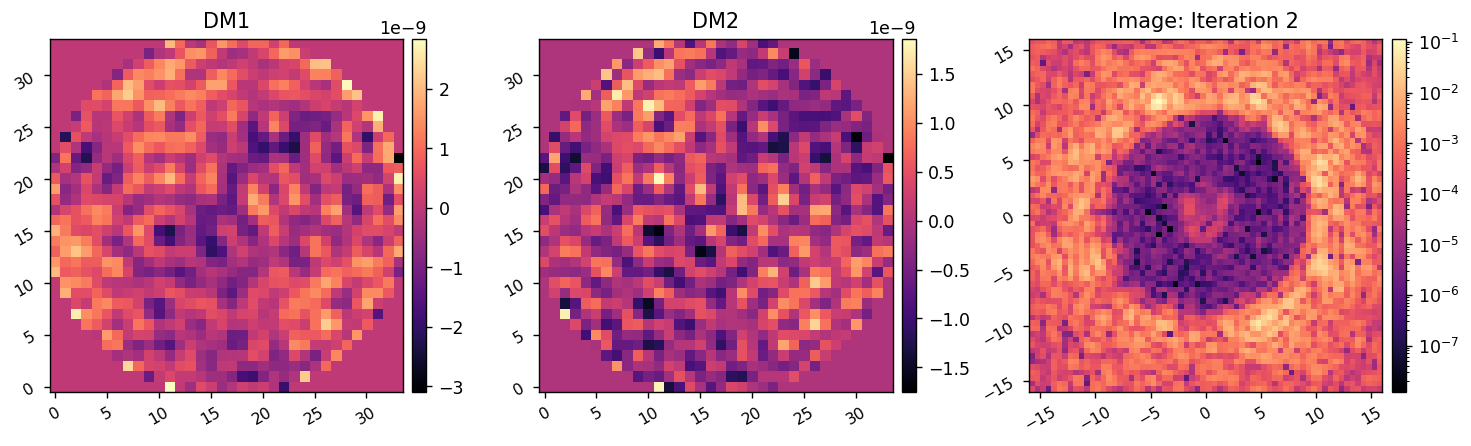

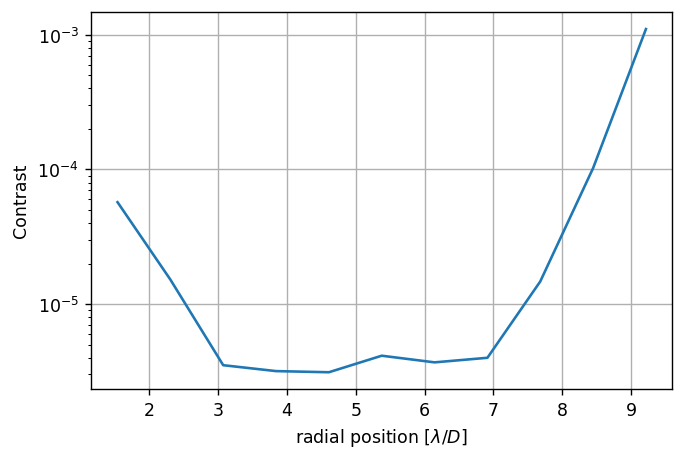

	Closed-loop iteration 3 / 10


(792,)

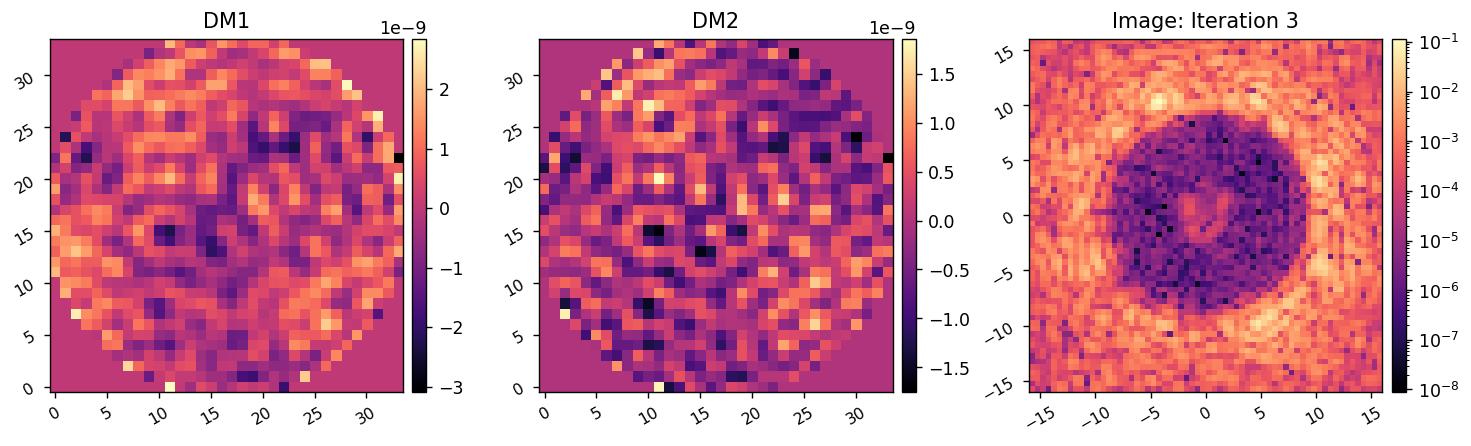

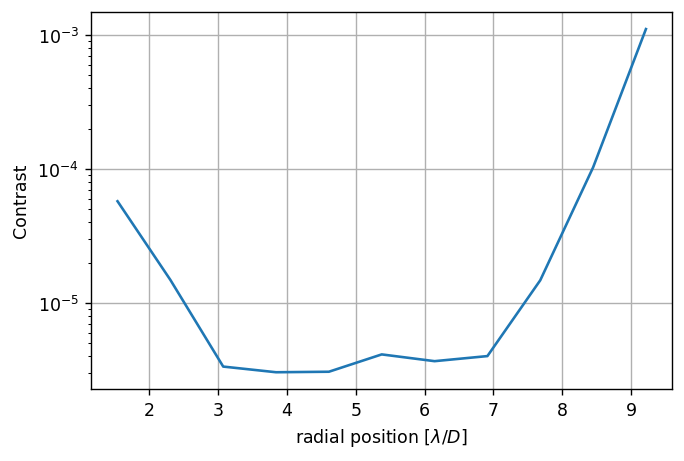

	Closed-loop iteration 4 / 10


(792,)

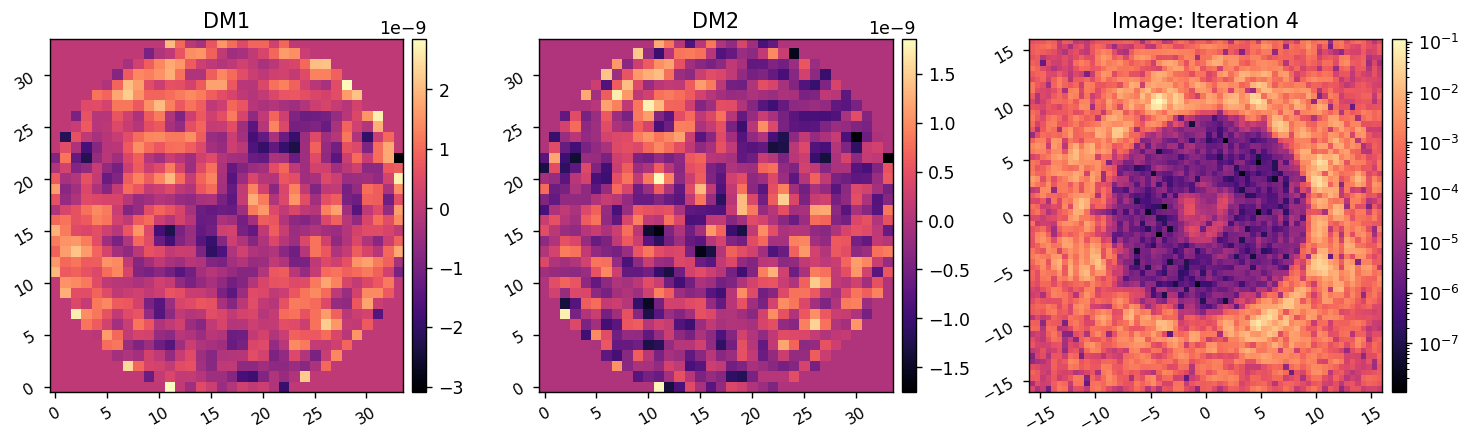

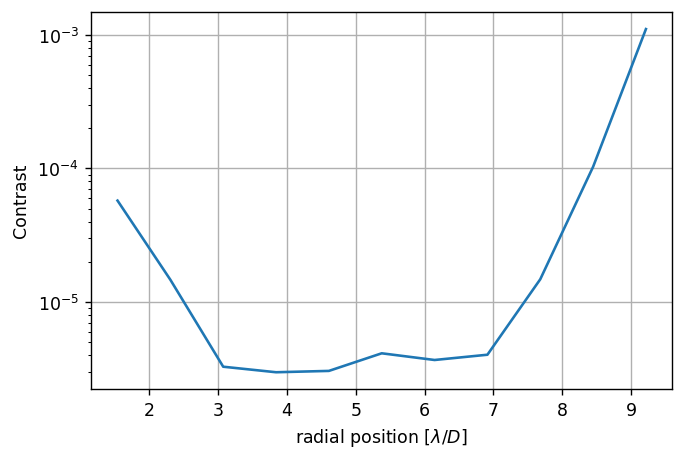

	Closed-loop iteration 5 / 10


(792,)

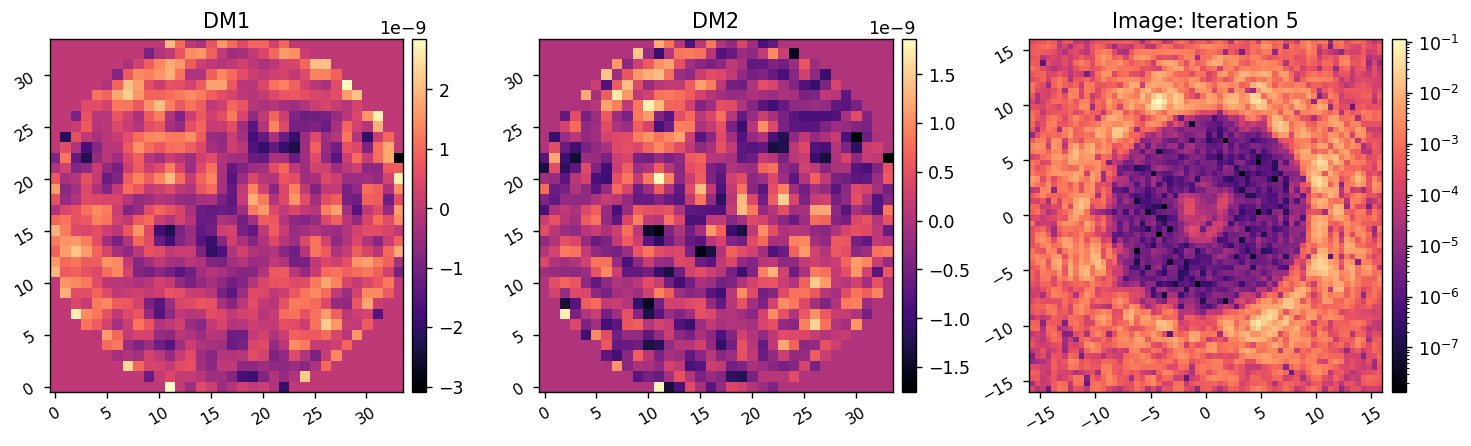

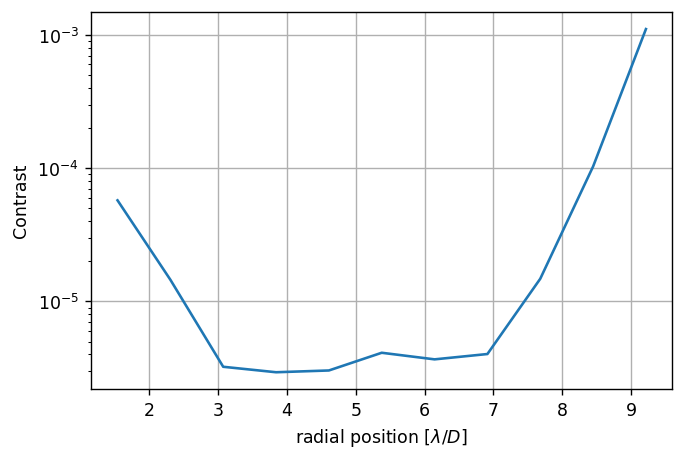

	Closed-loop iteration 6 / 10


(792,)

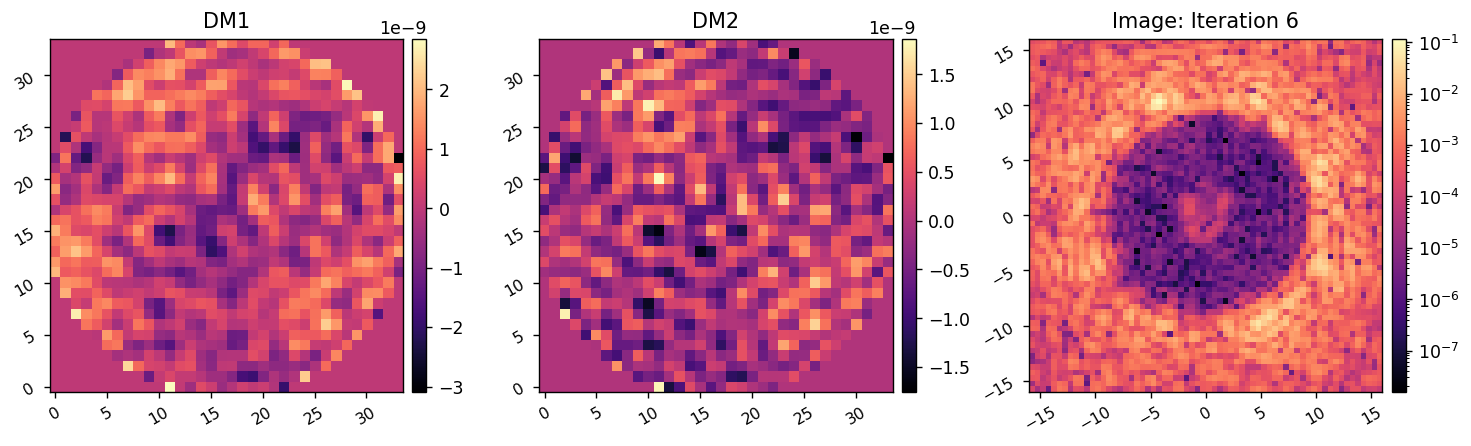

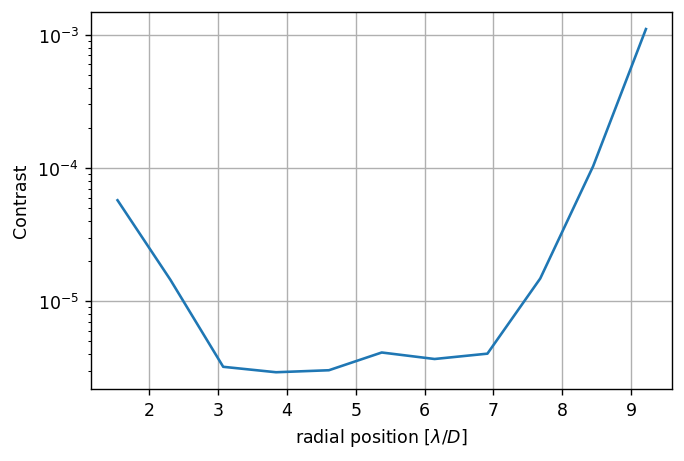

	Closed-loop iteration 7 / 10


(792,)

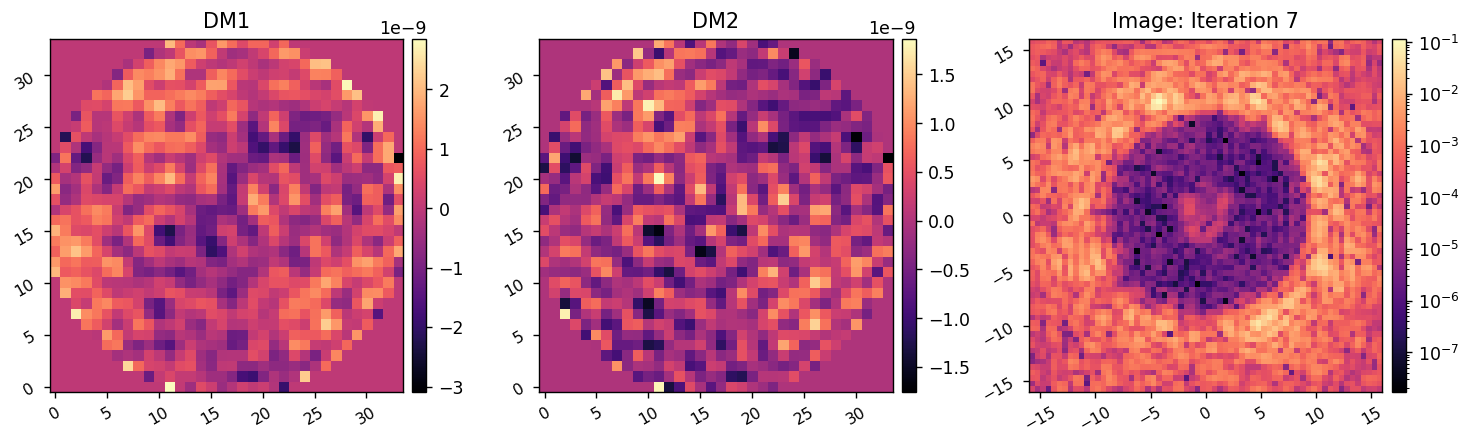

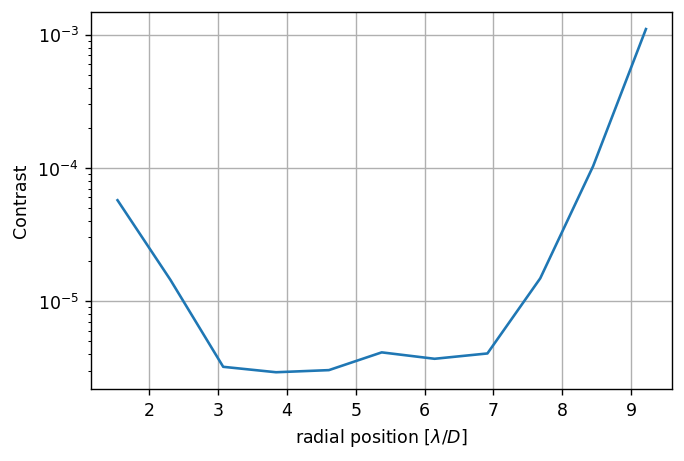

	Closed-loop iteration 8 / 10


(792,)

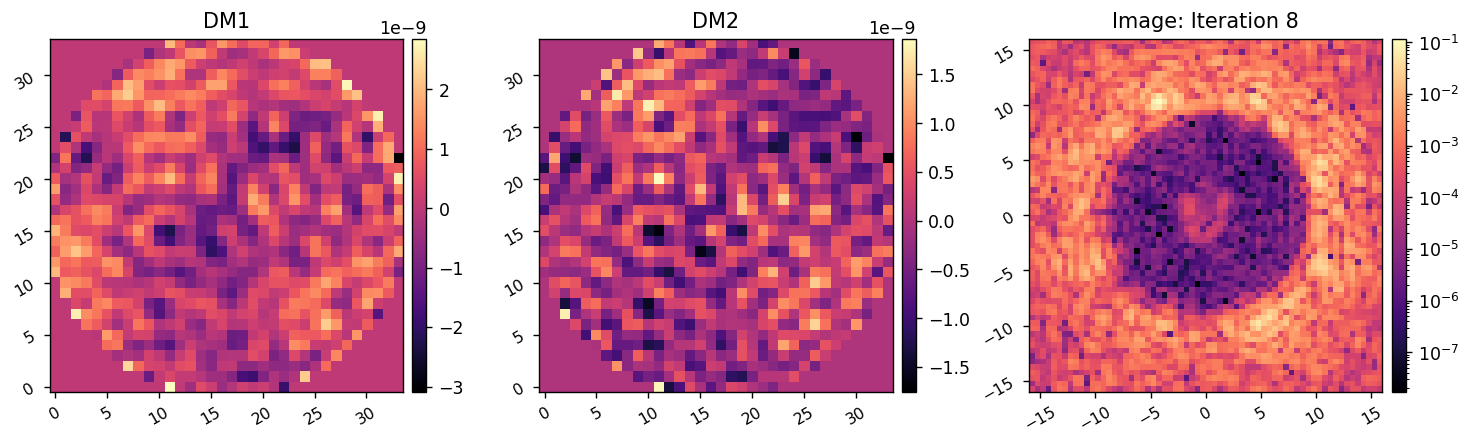

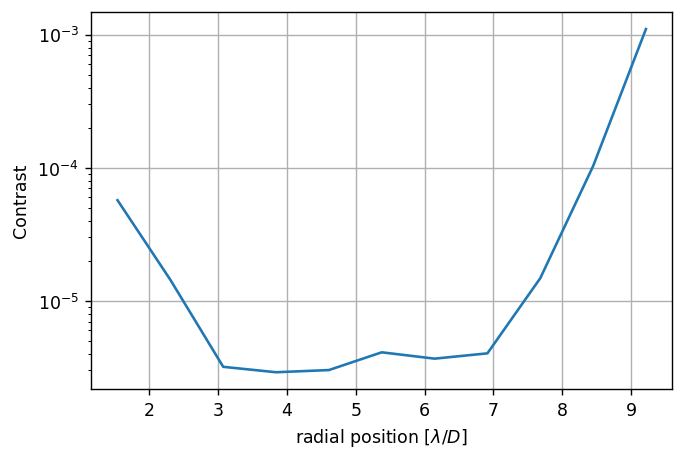

	Closed-loop iteration 9 / 10


(792,)

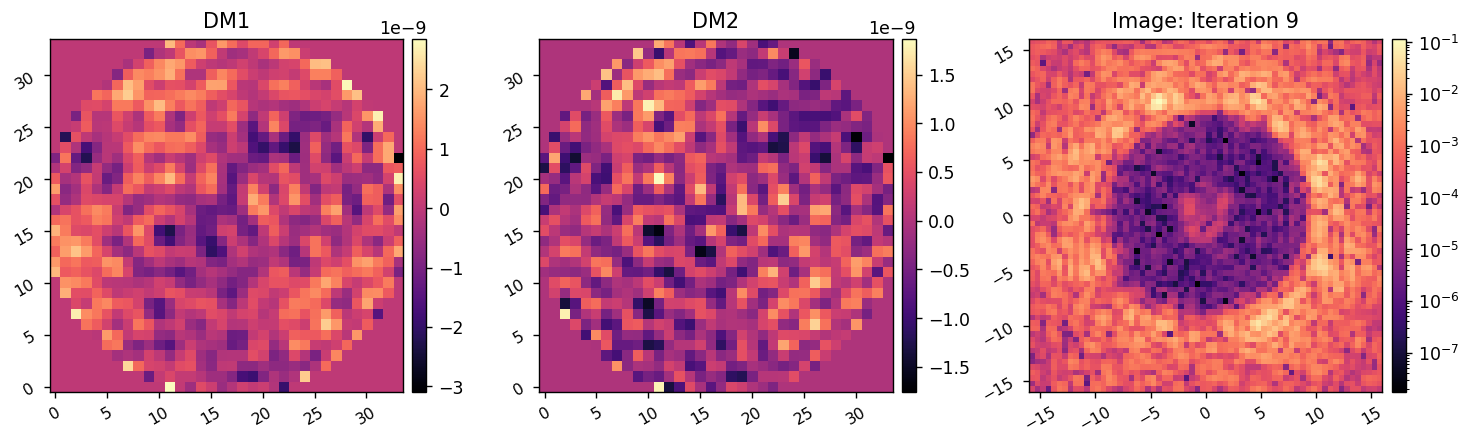

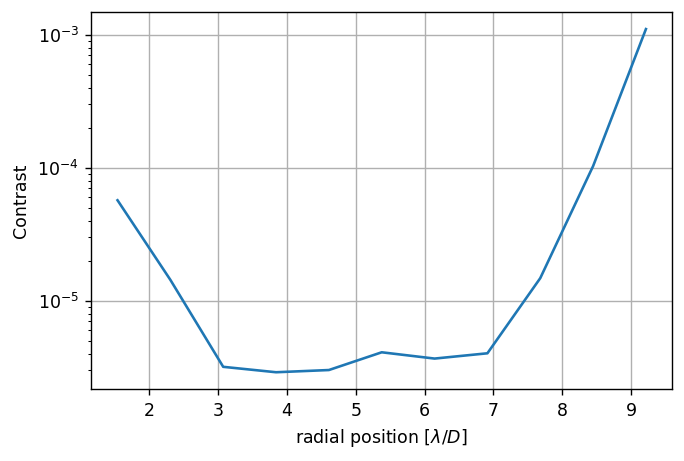

	Closed-loop iteration 10 / 10


(792,)

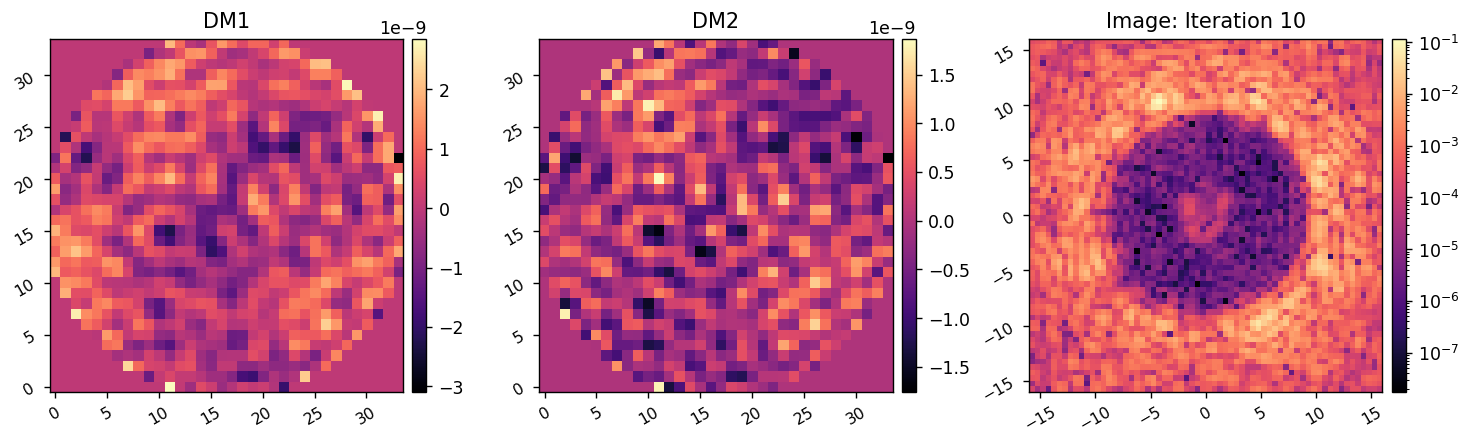

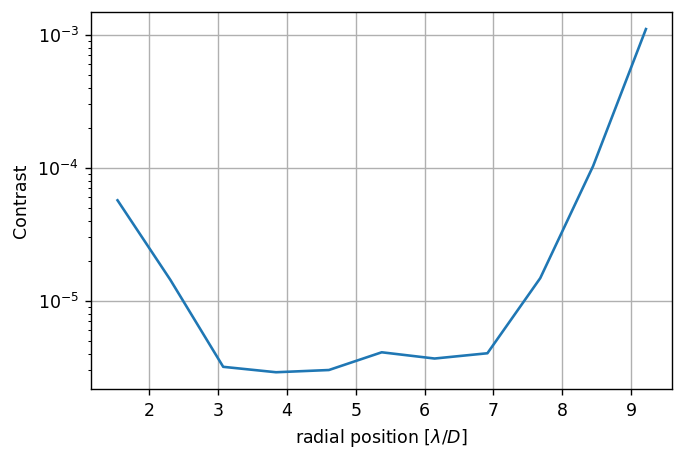

I-EFC loop completed in 21.861s.
Running I-EFC...
	Closed-loop iteration 1 / 10


(792,)

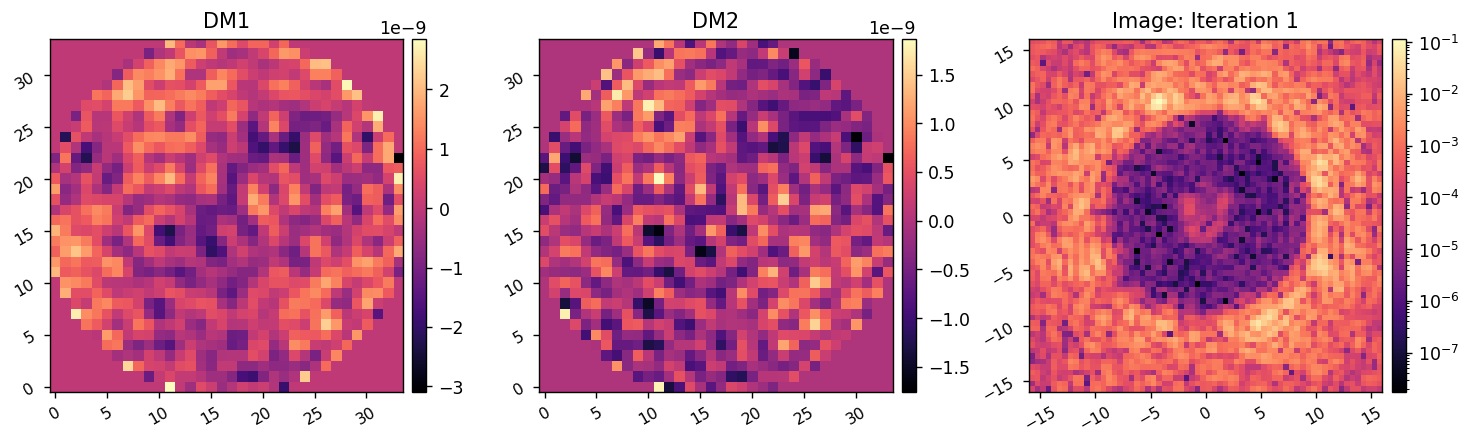

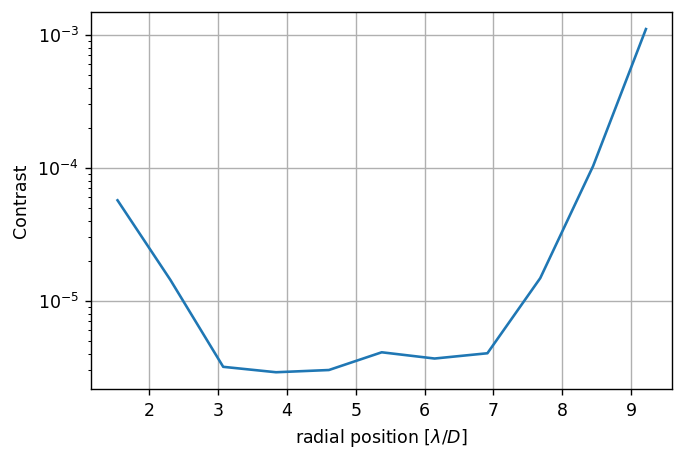

	Closed-loop iteration 2 / 10


(792,)

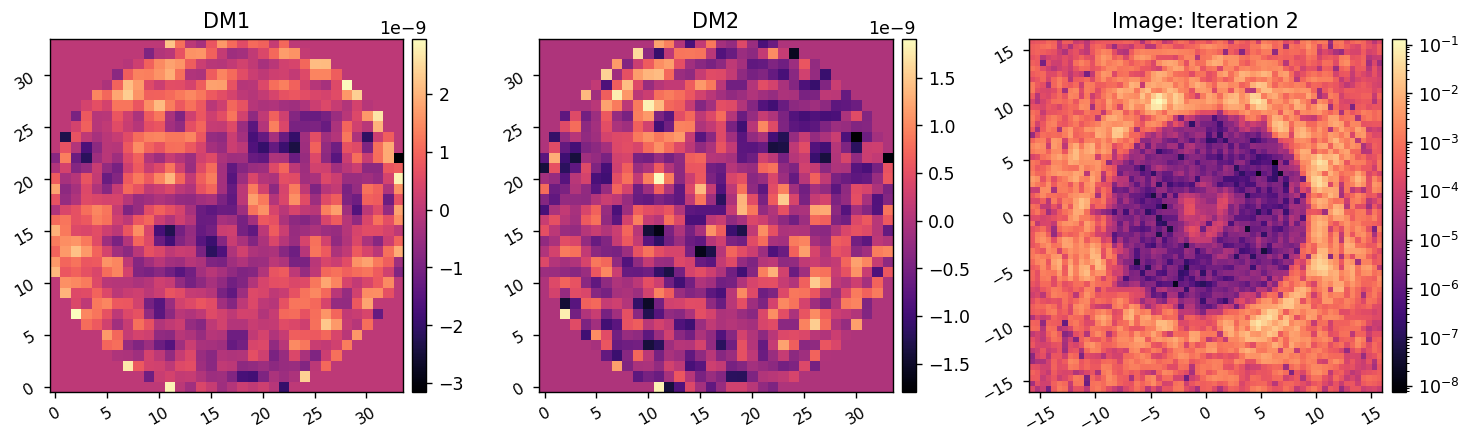

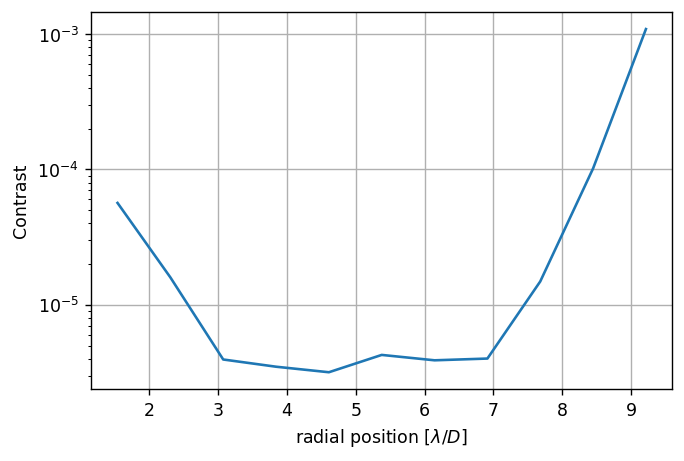

	Closed-loop iteration 3 / 10


(792,)

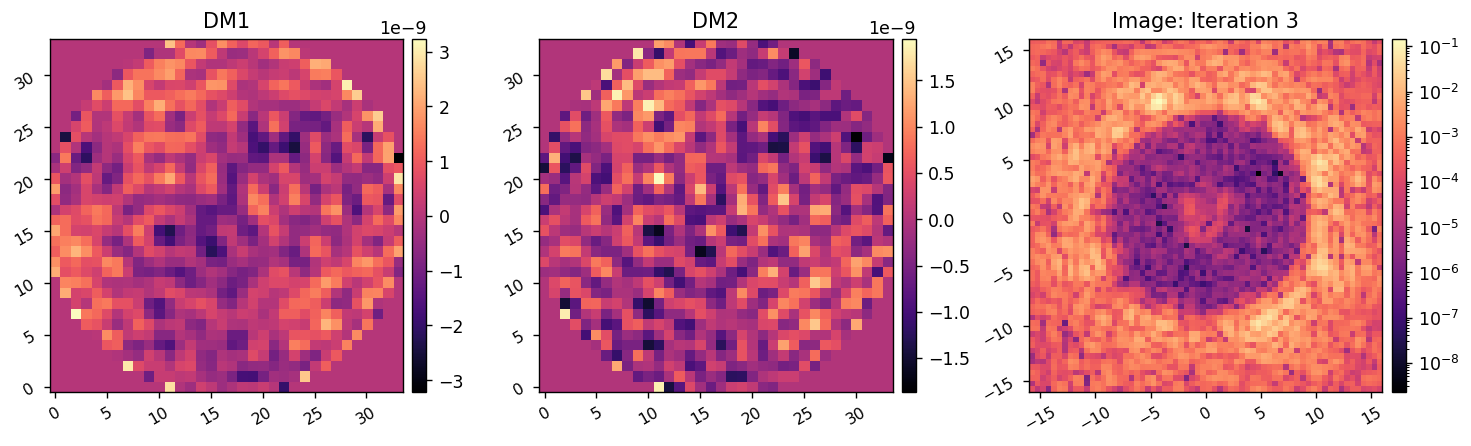

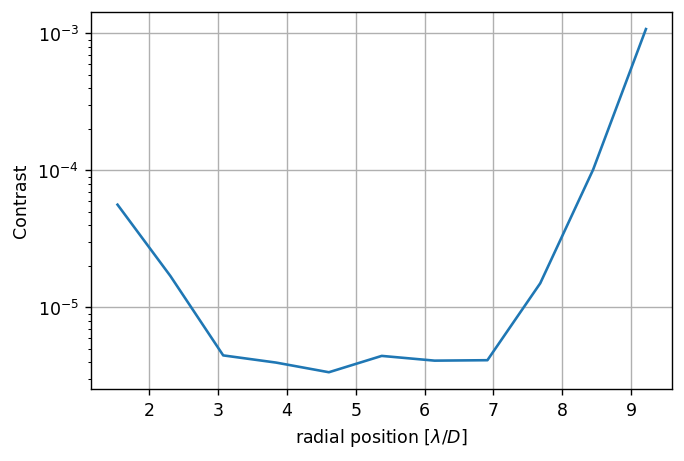

	Closed-loop iteration 4 / 10


(792,)

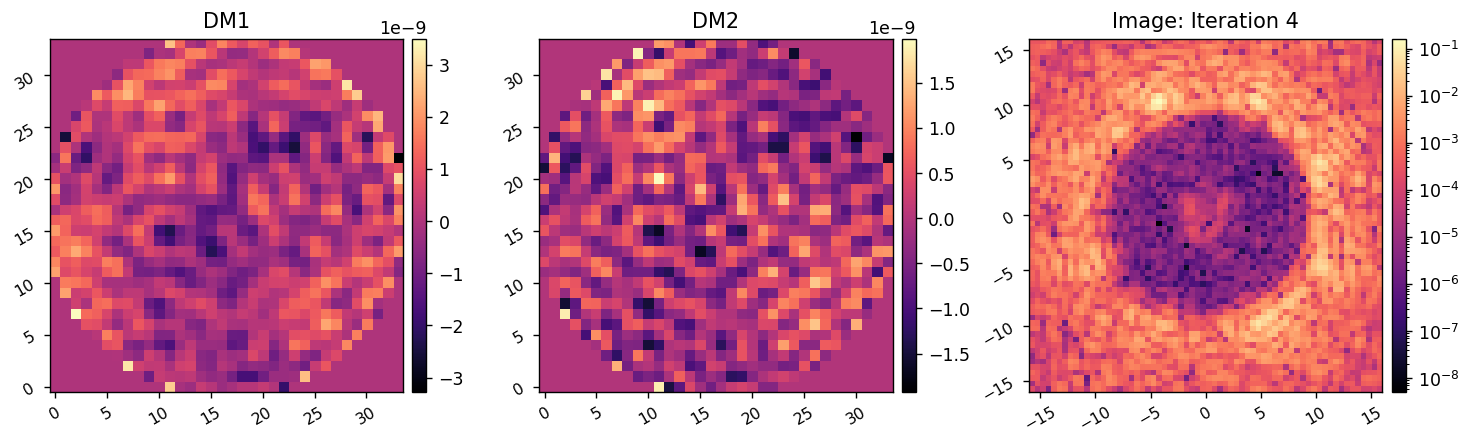

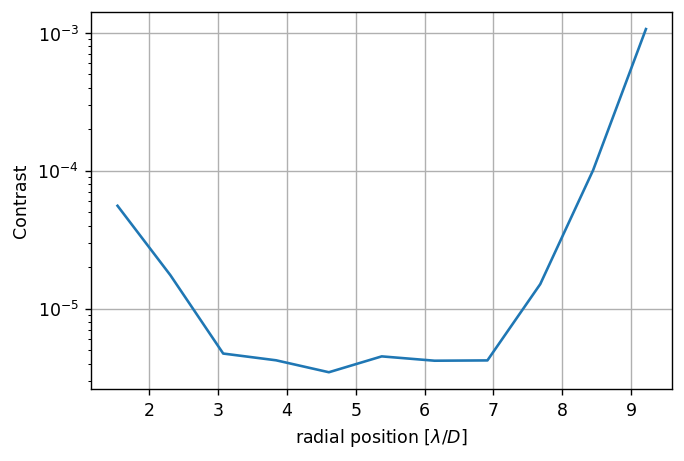

	Closed-loop iteration 5 / 10


(792,)

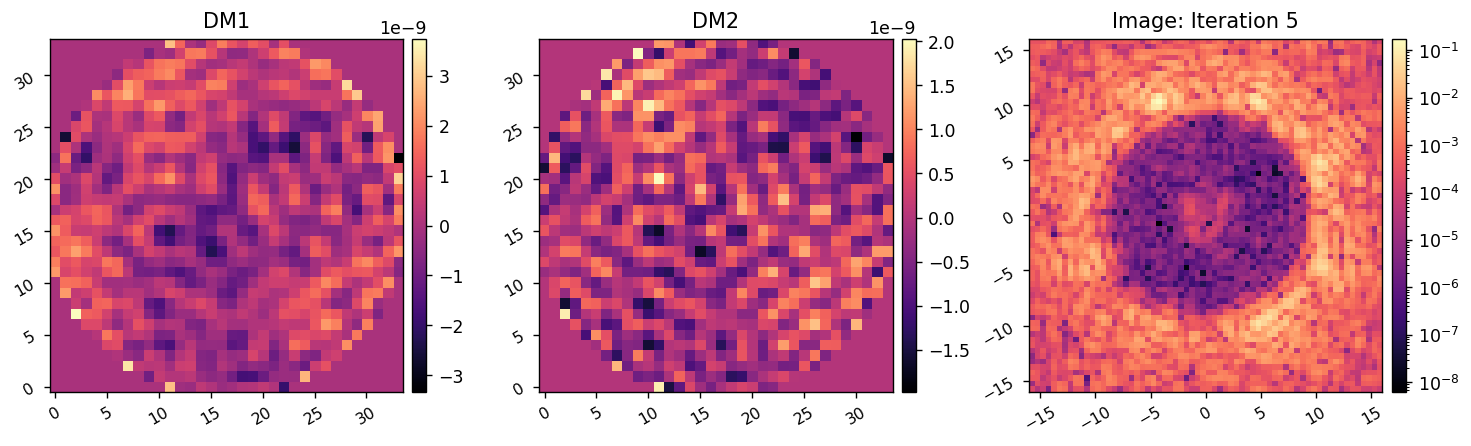

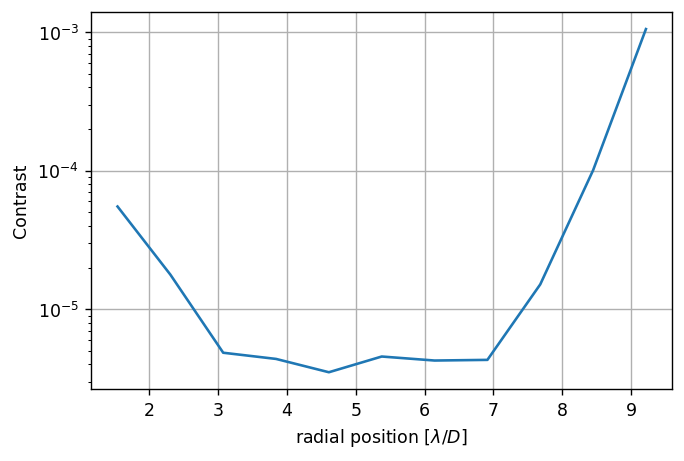

	Closed-loop iteration 6 / 10


(792,)

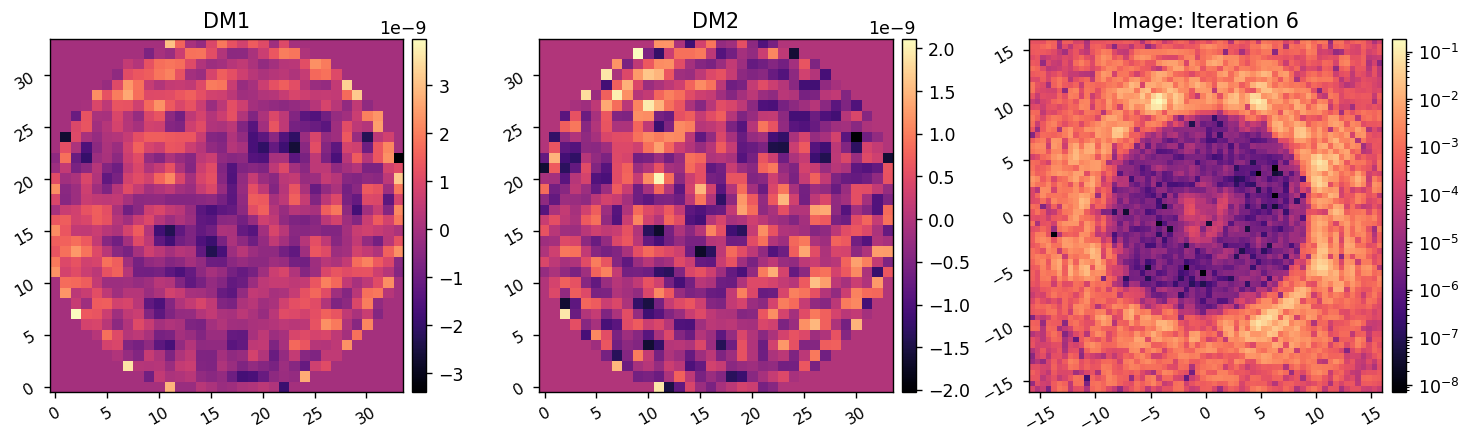

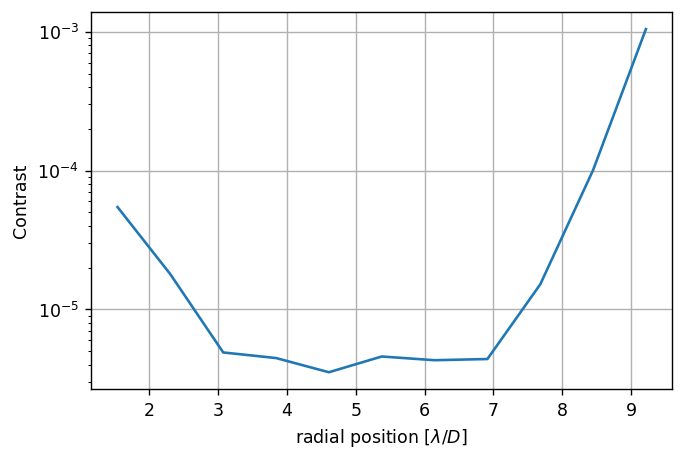

	Closed-loop iteration 7 / 10


(792,)

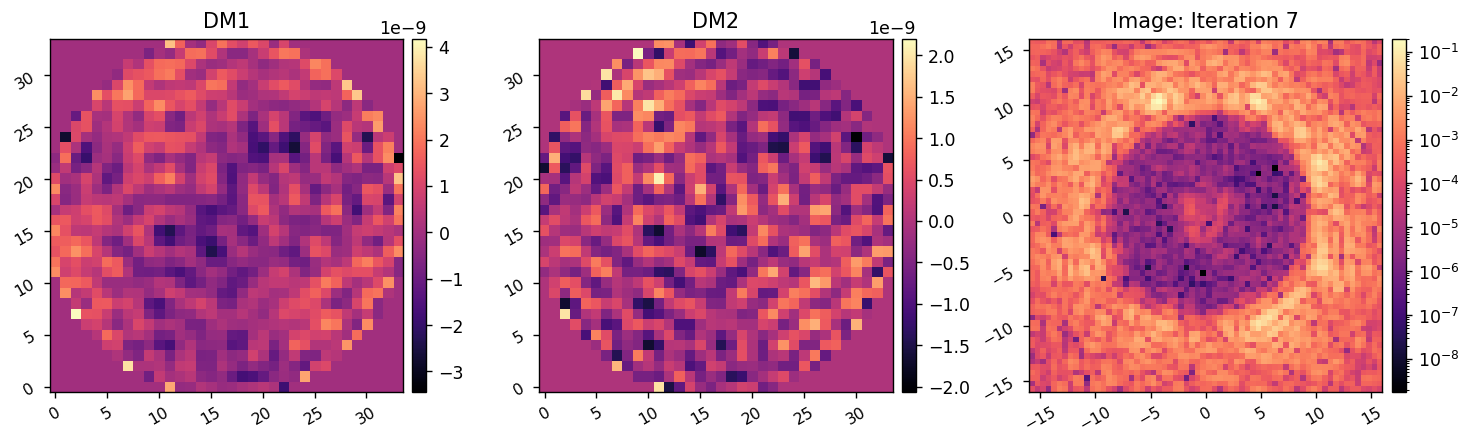

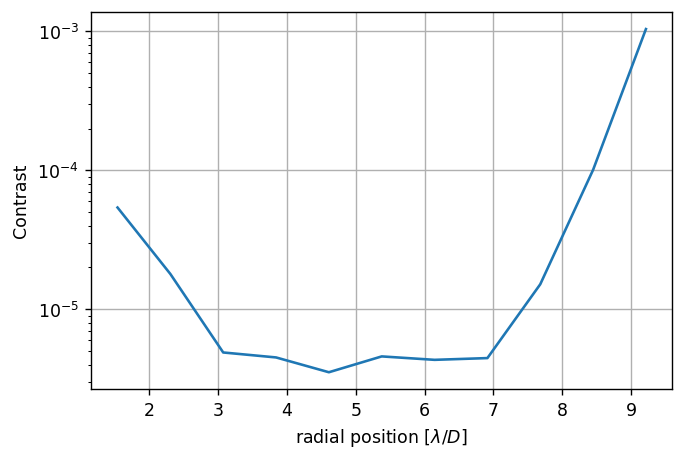

	Closed-loop iteration 8 / 10


(792,)

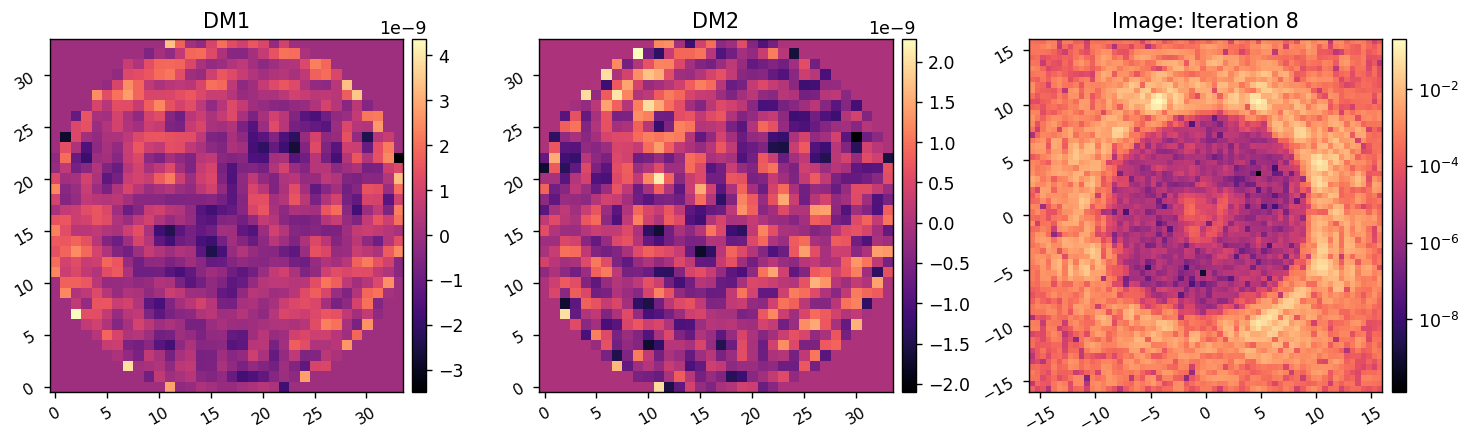

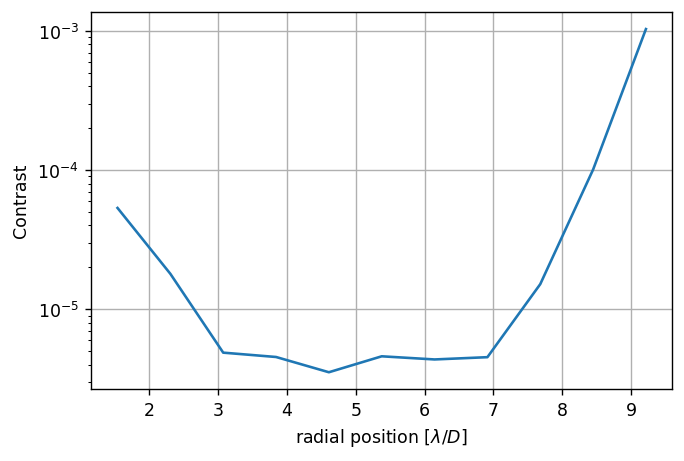

	Closed-loop iteration 9 / 10


(792,)

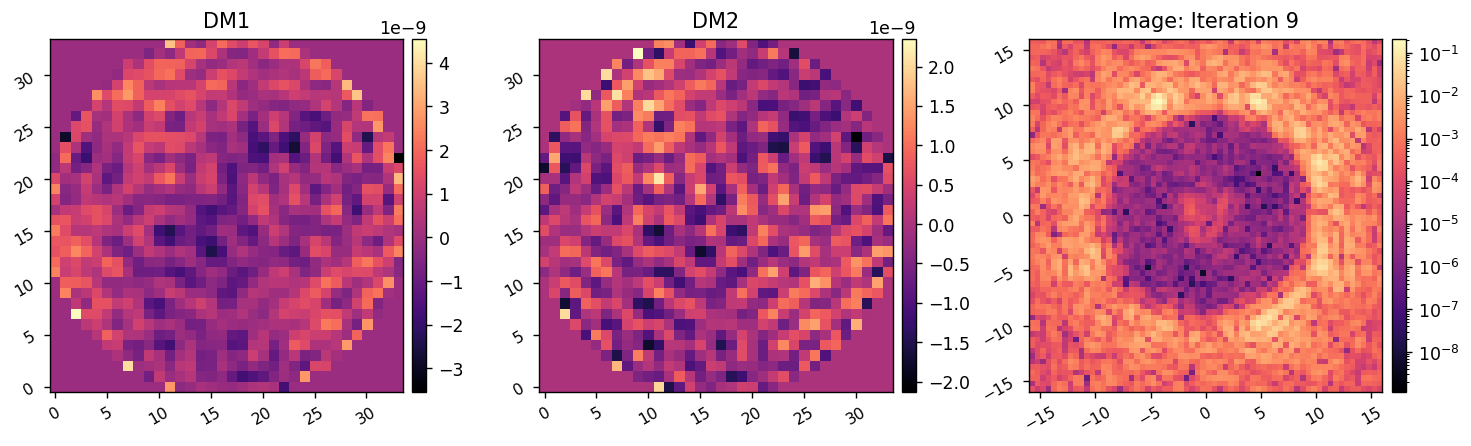

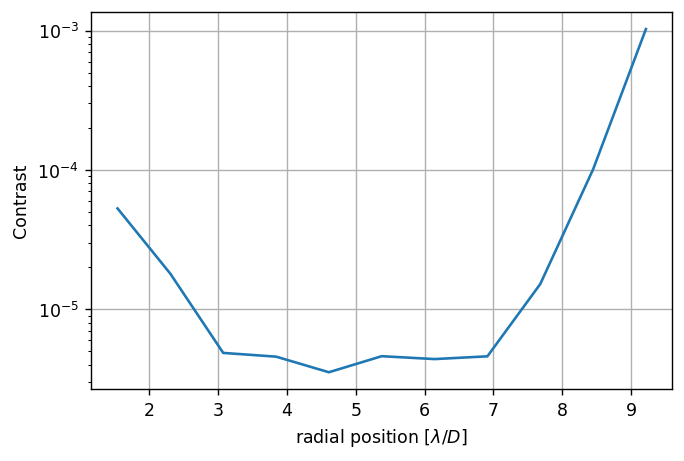

	Closed-loop iteration 10 / 10


(792,)

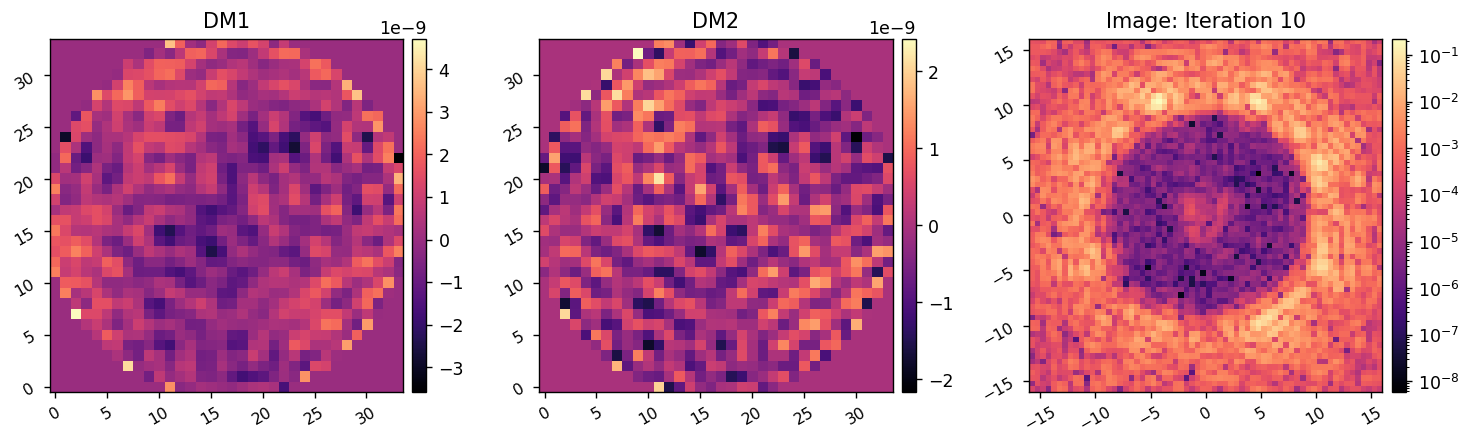

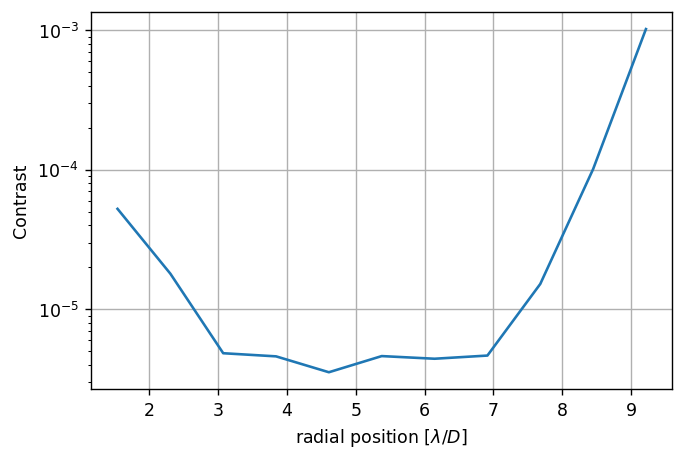

I-EFC loop completed in 21.547s.


In [25]:
reload(wfsc.iefc_2dm)
reload(wfsc.utils)

c.reset_dms()

reg_conds = [(1e-2,10), (1e-5, 20), (1e-3, 10), (1e-6,10)]

Wmatrix = np.diag(np.concatenate((weight_map[control_mask], weight_map[control_mask], weight_map[control_mask])))

for i in range(len(reg_conds)):
    
    cm_tik = wfsc.utils.TikhonovInverse(response_matrix, rcond=reg_conds[i][0])
    cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, Wmatrix, rcond=reg_conds[i][0])
    
    images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                              cm_wls,
                                              probe_modes, 
                                              probe_amp, 
                                              fourier_modes,
                                              control_mask, 
                                              num_iterations=reg_conds[i][1], 
                                              loop_gain=0.5, 
                                              leakage=0.0,
                                              plot_all=True,
                                             )